# W1D3

# Generalized Linear Models

## Intro

Some algorithms you might know, such as linear regression, logistic regression, and Poisson regression, are all just special cases of GLMs. They are very useful if you want to study encoding (i.e., predict neural activity from external covariates) or decoding (i.e., predict a behavior or intention from neural activity).

GLM is linear combination of values with thetas as coefficients plus noise that follows a distribution, layered with a nonlinear function

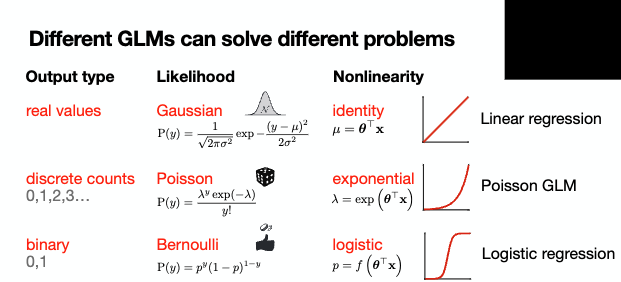

## Tutorial 1: GLMs for Encoding

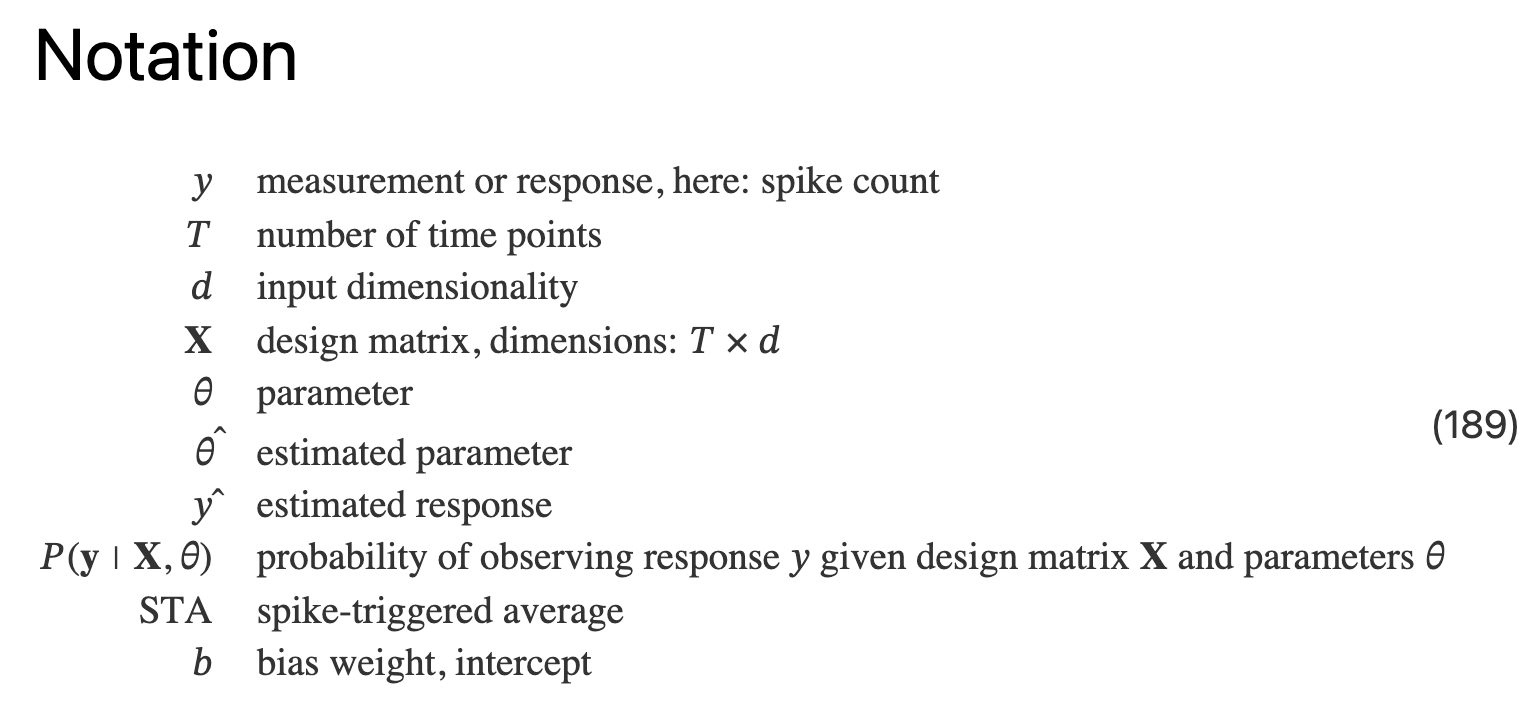

In this exercise we use data from an experiment that presented a screen which randomly alternated between two luminance values and recorded responses from retinal ganglion cell (RGC), a type of neuron in the retina in the back of the eye. This kind of visual stimulus is called a “full-field flicker”, and it was presented at ~120Hz (ie. the stimulus presented on the screen was refreshed about every 8ms). These same time bins were used to count the number of spikes emitted by each neuron.

In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat

In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

### Section 1: Linear-Gaussian GLM

In [3]:
# @title Plotting Functions

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
  """Show time series of stim intensity and spike counts.

  Args:
    stim (1D array): vector of stimulus intensities
    spikes (1D array): vector of spike counts
    dt (number): duration of each time step
    nt (number): number of time steps to plot

  """
  timepoints = np.arange(nt)
  time = timepoints * dt

  f, (ax_stim, ax_spikes) = plt.subplots(
    nrows=2, sharex=True, figsize=(8, 5),
  )
  ax_stim.plot(time, stim[timepoints])
  ax_stim.set_ylabel('Stimulus intensity')

  ax_spikes.plot(time, spikes[timepoints])
  ax_spikes.set_xlabel('Time (s)')
  ax_spikes.set_ylabel('Number of spikes')

  f.tight_layout()
  plt.show()


def plot_glm_matrices(X, y, nt=50):
  """Show X and Y as heatmaps.

  Args:
    X (2D array): Design matrix.
    y (1D or 2D array): Target vector.

  """
  from matplotlib.colors import BoundaryNorm
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  Y = np.c_[y]  # Ensure Y is 2D and skinny

  f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(6, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )
  norm = BoundaryNorm([-1, -.2, .2, 1], 256)
  imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)

  ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[4, 14, 24],
    xticklabels=['-20', '-10', '0'],
    ylabel="Time point (time bins)",
  )
  plt.setp(ax_x.spines.values(), visible=True)

  divx = make_axes_locatable(ax_x)
  caxx = divx.append_axes("right", size="5%", pad=0.1)
  cbarx = f.colorbar(imx, cax=caxx)
  cbarx.set_ticks([-.6, 0, .6])
  cbarx.set_ticklabels(np.sort(np.unique(X)))

  norm = BoundaryNorm(np.arange(y.max() + 1), 256)
  imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
  ax_y.set(
    title="Y\n(spike count)",
    xticks=[]
  )
  ax_y.invert_yaxis()
  plt.setp(ax_y.spines.values(), visible=True)

  divy = make_axes_locatable(ax_y)
  caxy = divy.append_axes("right", size="30%", pad=0.1)
  cbary = f.colorbar(imy, cax=caxy)
  cbary.set_ticks(np.arange(y.max()) + .5)
  cbary.set_ticklabels(np.arange(y.max()))
  plt.show()


def plot_spike_filter(theta, dt, show=True, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()
    show (boolean): To plt.show or not the plot.
  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )
  if show:
    plt.show()


def plot_spikes_with_prediction(spikes, predicted_spikes, dt,
                                nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    show (boolean): To plt.show or not the plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt])
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  plt.show()

In [4]:
# @title Data retrieval and loading
import os
import hashlib
import requests

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

#### Section 1.1: Load retinal ganglion cell activity data

In [5]:
data = loadmat('RGCdata.mat')  # loadmat is a function in scipy.io
dt_stim = data['dtStim'].item()  # .item extracts a scalar value

# Extract the stimulus intensity
stim = data['Stim'].squeeze()  # .squeeze removes dimensions with 1 element

# Extract the spike counts for one cell
cellnum = 2
spikes = data['SpCounts'][:, cellnum]

# Don't use all of the timepoints in the dataset, for speed
keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]

In [10]:
len(stim)

20000

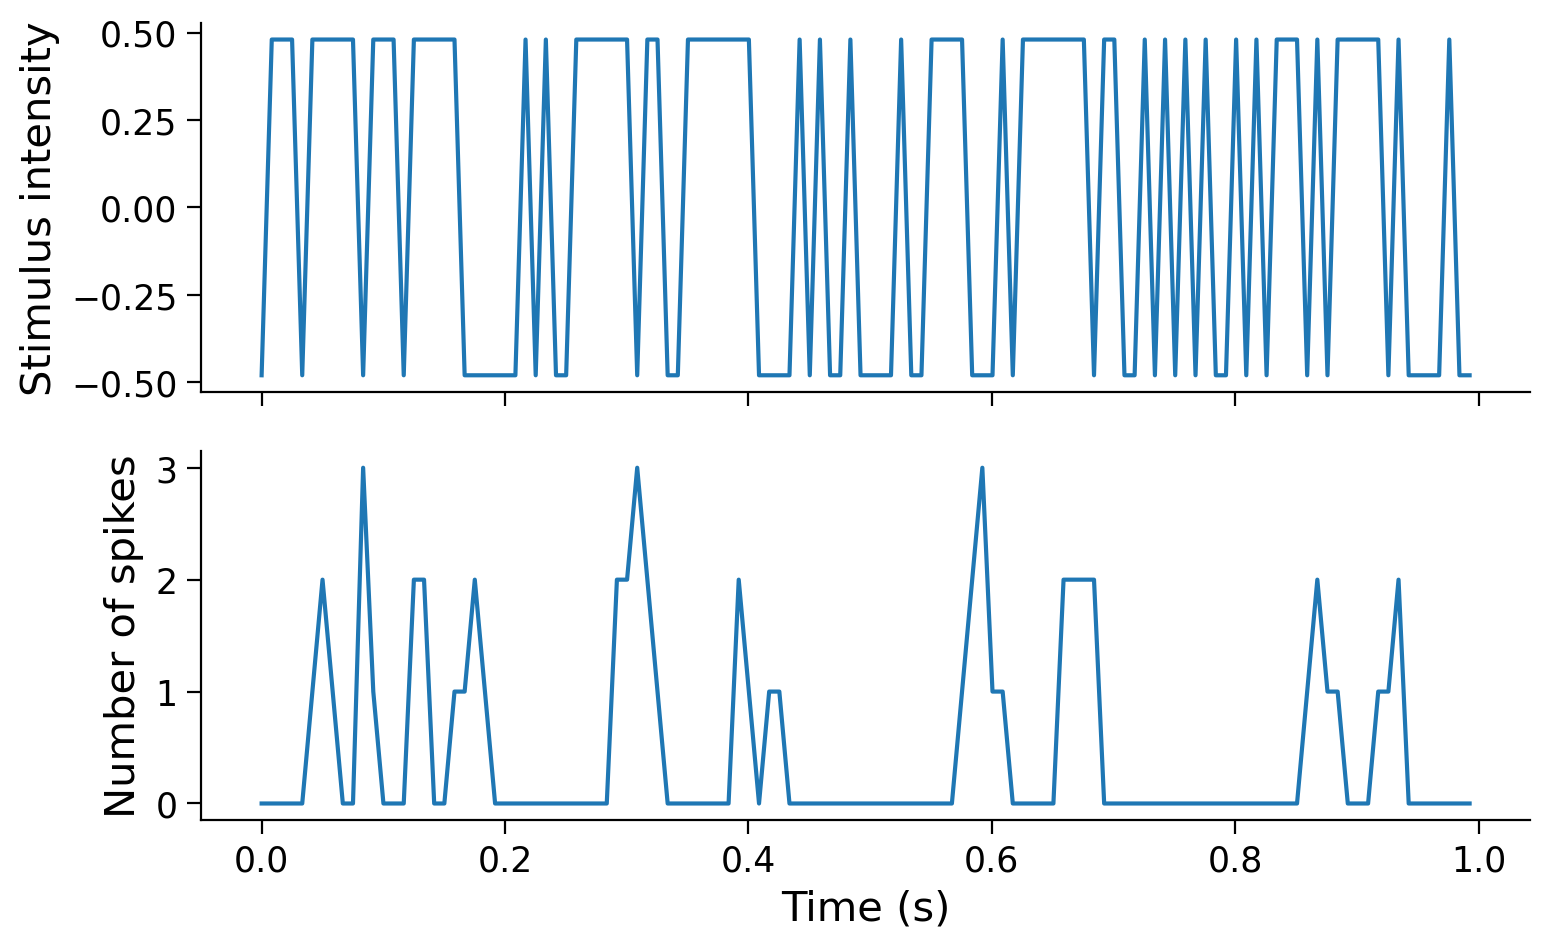

In [6]:
plot_stim_and_spikes(stim, spikes, dt_stim)

Our goal is to predict the cell’s activity from the stimulus intensities preceding it.

In this exercise, we will create the design matrix 𝐗
 using 𝑑=25
 time lags. That is, 𝐗
 should be a 𝑇×𝑑
 matrix. 𝑑=25
 (about 200 ms) is a choice we’re making based on our prior knowledge of the temporal window that influences RGC responses. In practice, you might not know the right duration to use.

The last entry in row t should correspond to the stimulus that was shown at time t, the entry to the left of it should contain the value that was shown one time bin earlier, etc. Specifically, 𝑋𝑖𝑗
 will be the stimulus intensity at time 𝑖+𝑑−1−𝑗
.

Note that for the first few time bins, we have access to the recorded spike counts but not to the stimulus shown in the recent past. For simplicity we are going to assume that values of stim are 0 for the time lags prior to the first timepoint in the dataset. This is known as “zero-padding”, so that the design matrix has the same number of rows as the response vectors in spikes.

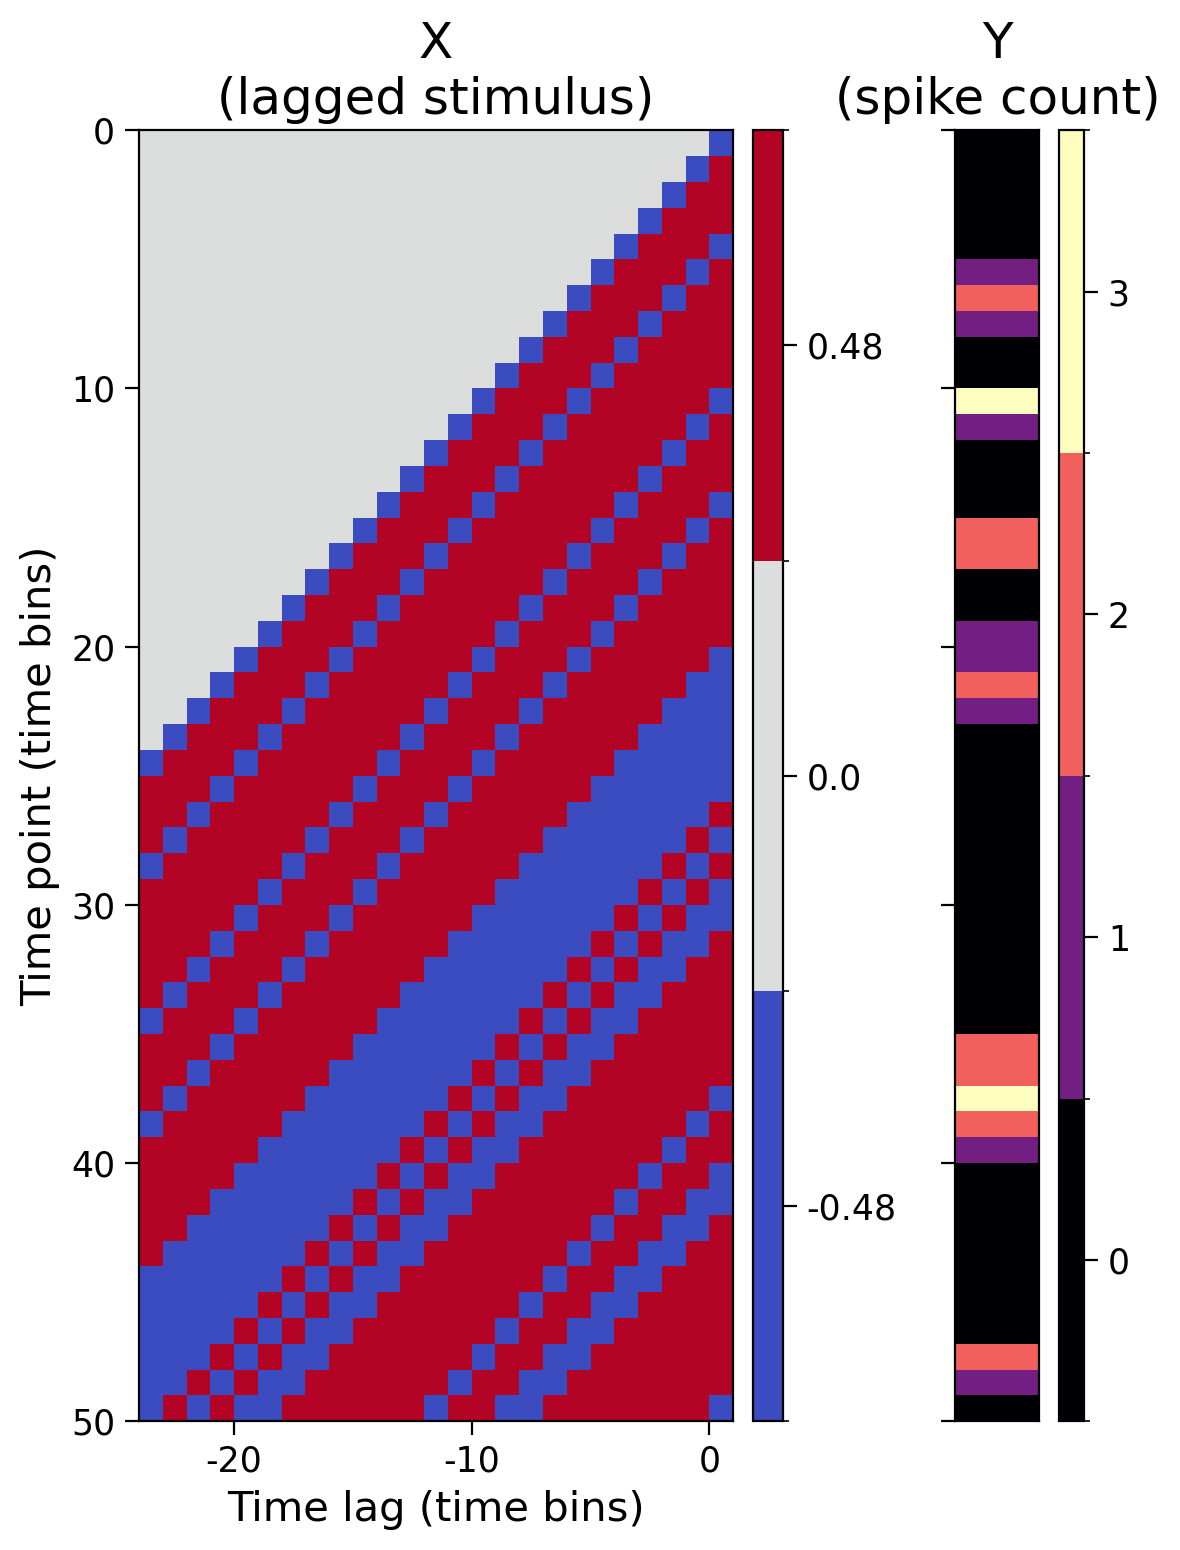

In [12]:
def make_design_matrix(stim, d=25):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t+d]

  return X


# Make design matrix
X = make_design_matrix(stim)

# Visualize
plot_glm_matrices(X, spikes, nt=50)

In [13]:
X[:5]

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.48],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.48,  0.48],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  , -0.48,  0.48,  0.48],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  , -0.48,  0.48,  0.48,  0.48],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  , -0.48,  0.48,  0.48,  0.48, -0.48]])

#### Section 1.2: Fit Linear-Gaussian regression model

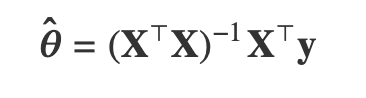

Before we can apply this equation, we need to augment the design matrix to account for the mean of 𝑦
, because the spike counts are all ≥0
. We do this by adding a constant column of 1’s to the design matrix, which will allow the model to learn an additive offset weight. We will refer to this additional weight as 𝑏
 (for bias), although it is alternatively known as a “DC term” or “intercept”.

In [14]:
# Build the full design matrix
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant, make_design_matrix(stim)])

# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [24]:
print(X)
print(X.shape)
print(theta)
print(theta.shape)

[[ 1.    0.    0.   ...  0.    0.   -0.48]
 [ 1.    0.    0.   ...  0.   -0.48  0.48]
 [ 1.    0.    0.   ... -0.48  0.48  0.48]
 ...
 [ 1.    0.48  0.48 ... -0.48  0.48 -0.48]
 [ 1.    0.48  0.48 ...  0.48 -0.48 -0.48]
 [ 1.    0.48 -0.48 ... -0.48 -0.48 -0.48]]
(20000, 26)
[ 3.54577150e-01 -1.30069004e-02  3.41569302e-04  6.73822770e-03
  7.23694327e-03 -6.29805903e-04  1.77192831e-03 -5.33178172e-03
 -3.17713423e-02 -4.35242744e-02 -6.52148150e-02 -8.71033465e-02
 -8.81600231e-02 -1.39915563e-01 -1.51425398e-01 -1.65489263e-01
 -1.55096415e-01 -1.76273624e-01 -2.12515817e-01 -1.39405807e-01
  3.03378200e-01  5.75560571e-01  4.40597192e-01  1.37118832e-01
  1.60489968e-02 -1.66805519e-03]
(26,)


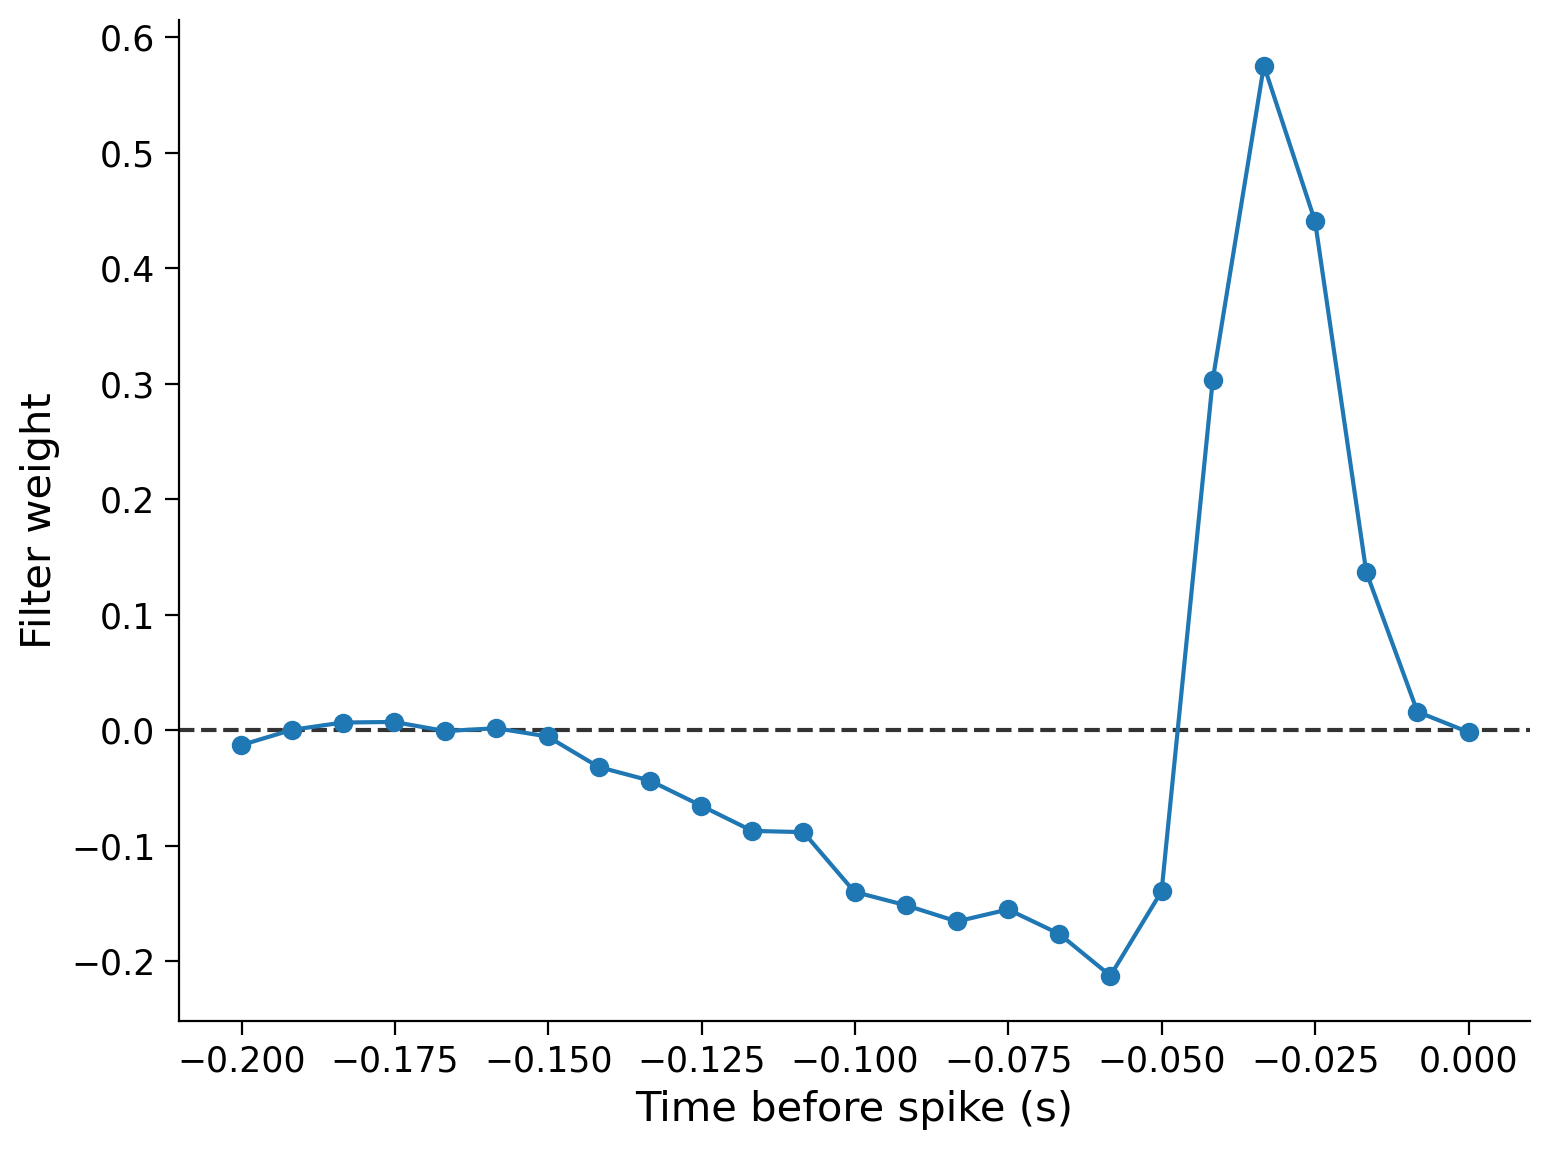

In [15]:
plot_spike_filter(theta_lg, dt_stim)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


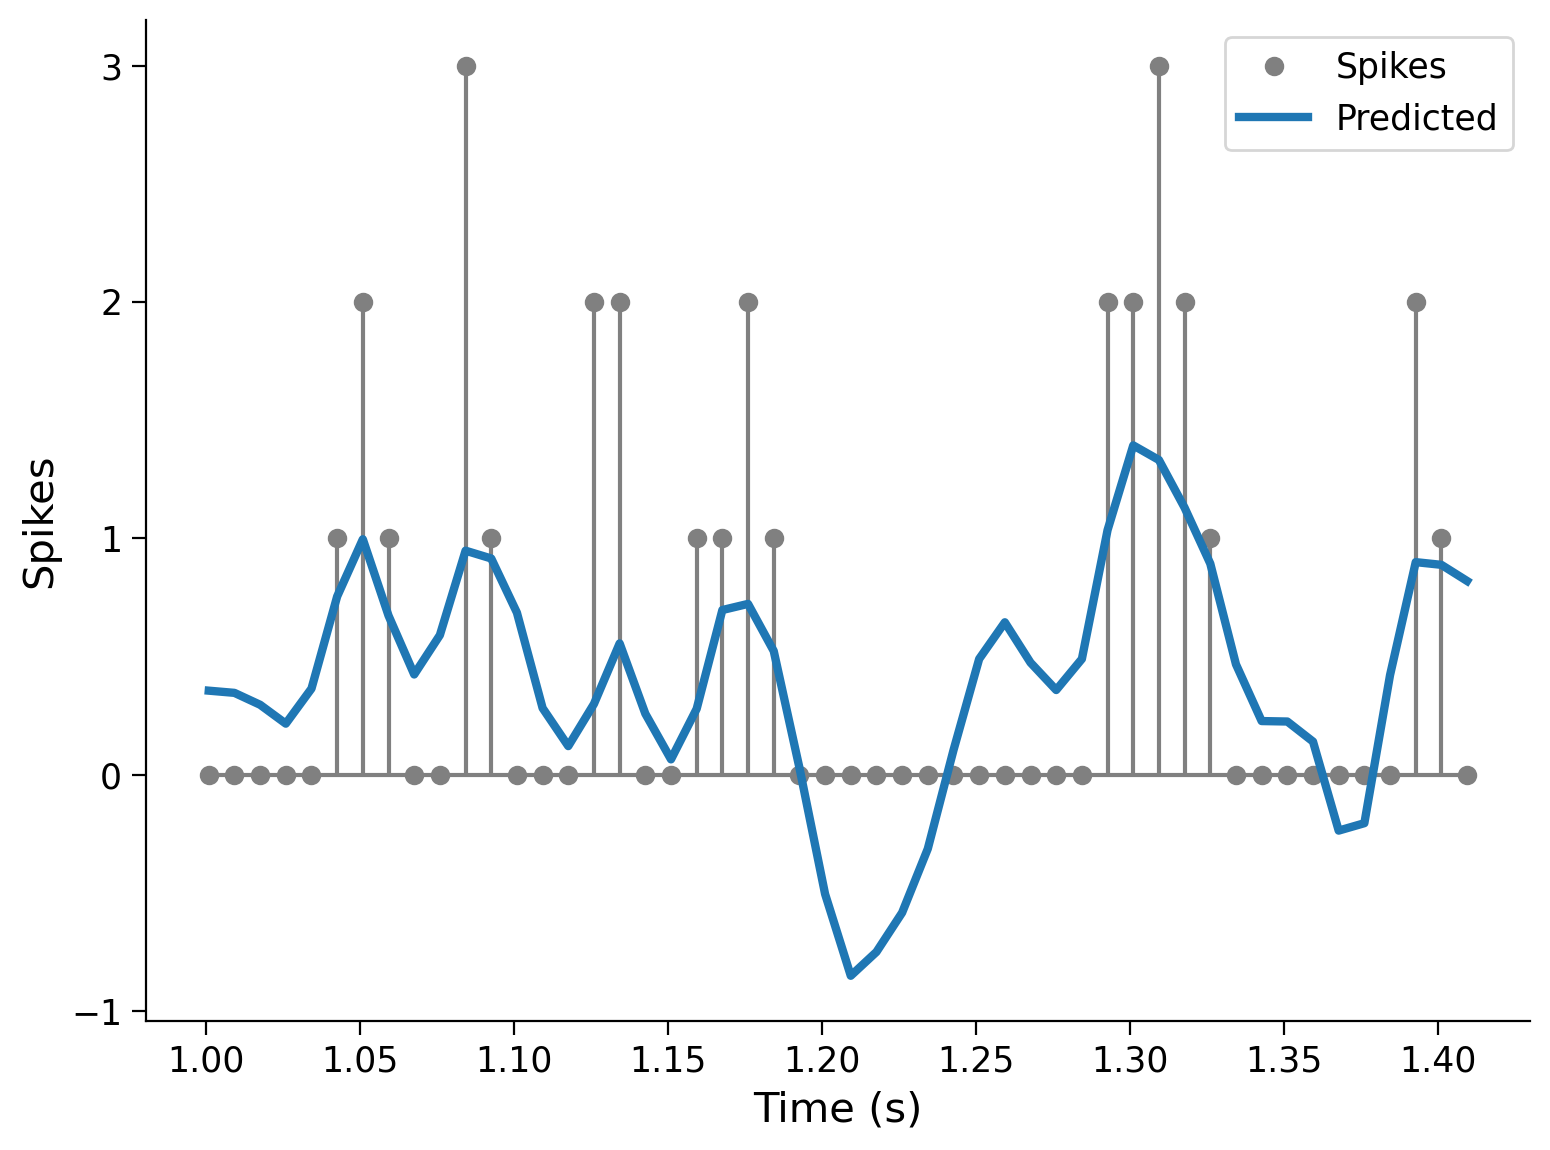

In [18]:
def predict_spike_counts_lg(stim, spikes, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """

  # Create the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Get the MLE weights for the LG model
  theta = np.linalg.inv(X.T @ X) @ (X.T @ y)

  # Compute predicted spike counts
  yhat = X @ theta

  return yhat


# Predict spike counts
predicted_counts = predict_spike_counts_lg(stim, spikes)

# Visualize
plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)

### Section 2: Linear-Nonlinear-Poisson GLM

Noise distribution needs to be non-negative and discrete. Need generalized linear model

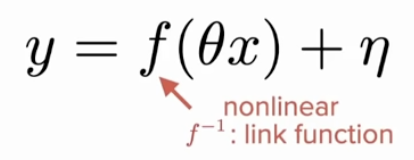

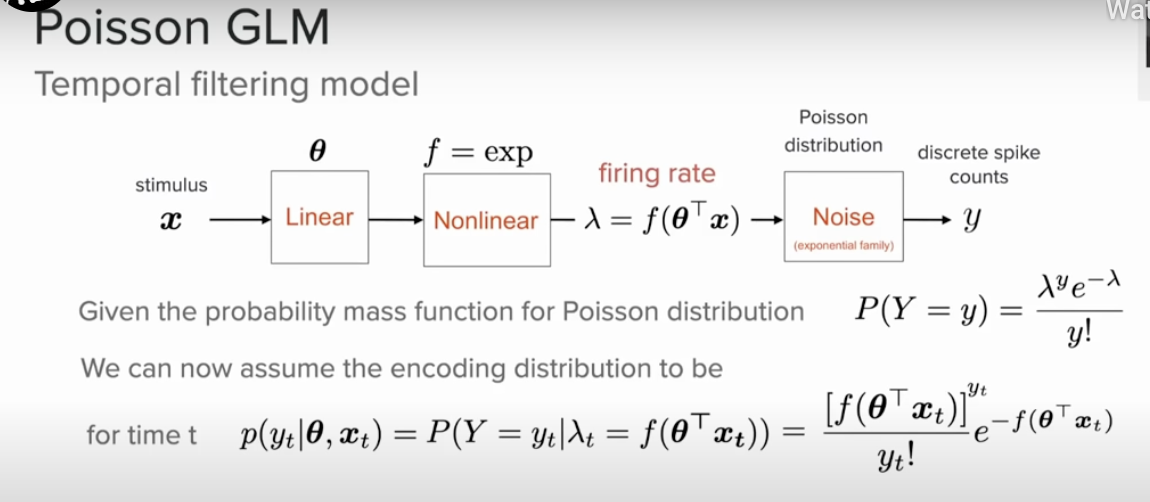

#### Section 2.1: Nonlinear optimization with scipy.optimize

Here we will use the scipy.optimize module, it contains a function called minimize that provides a generic interface to a large number of optimization algorithms. This function expects as argument an objective function and an “initial guess” for the parameter values. It then returns a dictionary that includes the minimum function value, the parameters that give this minimum, and other information.

In [25]:
f = np.square
res = minimize(f, x0=2)
print(f"Minimum value: {res['fun']:.4g} at x = {res['x'].item():.5e}")

Minimum value: 3.566e-16 at x = -1.88846e-08


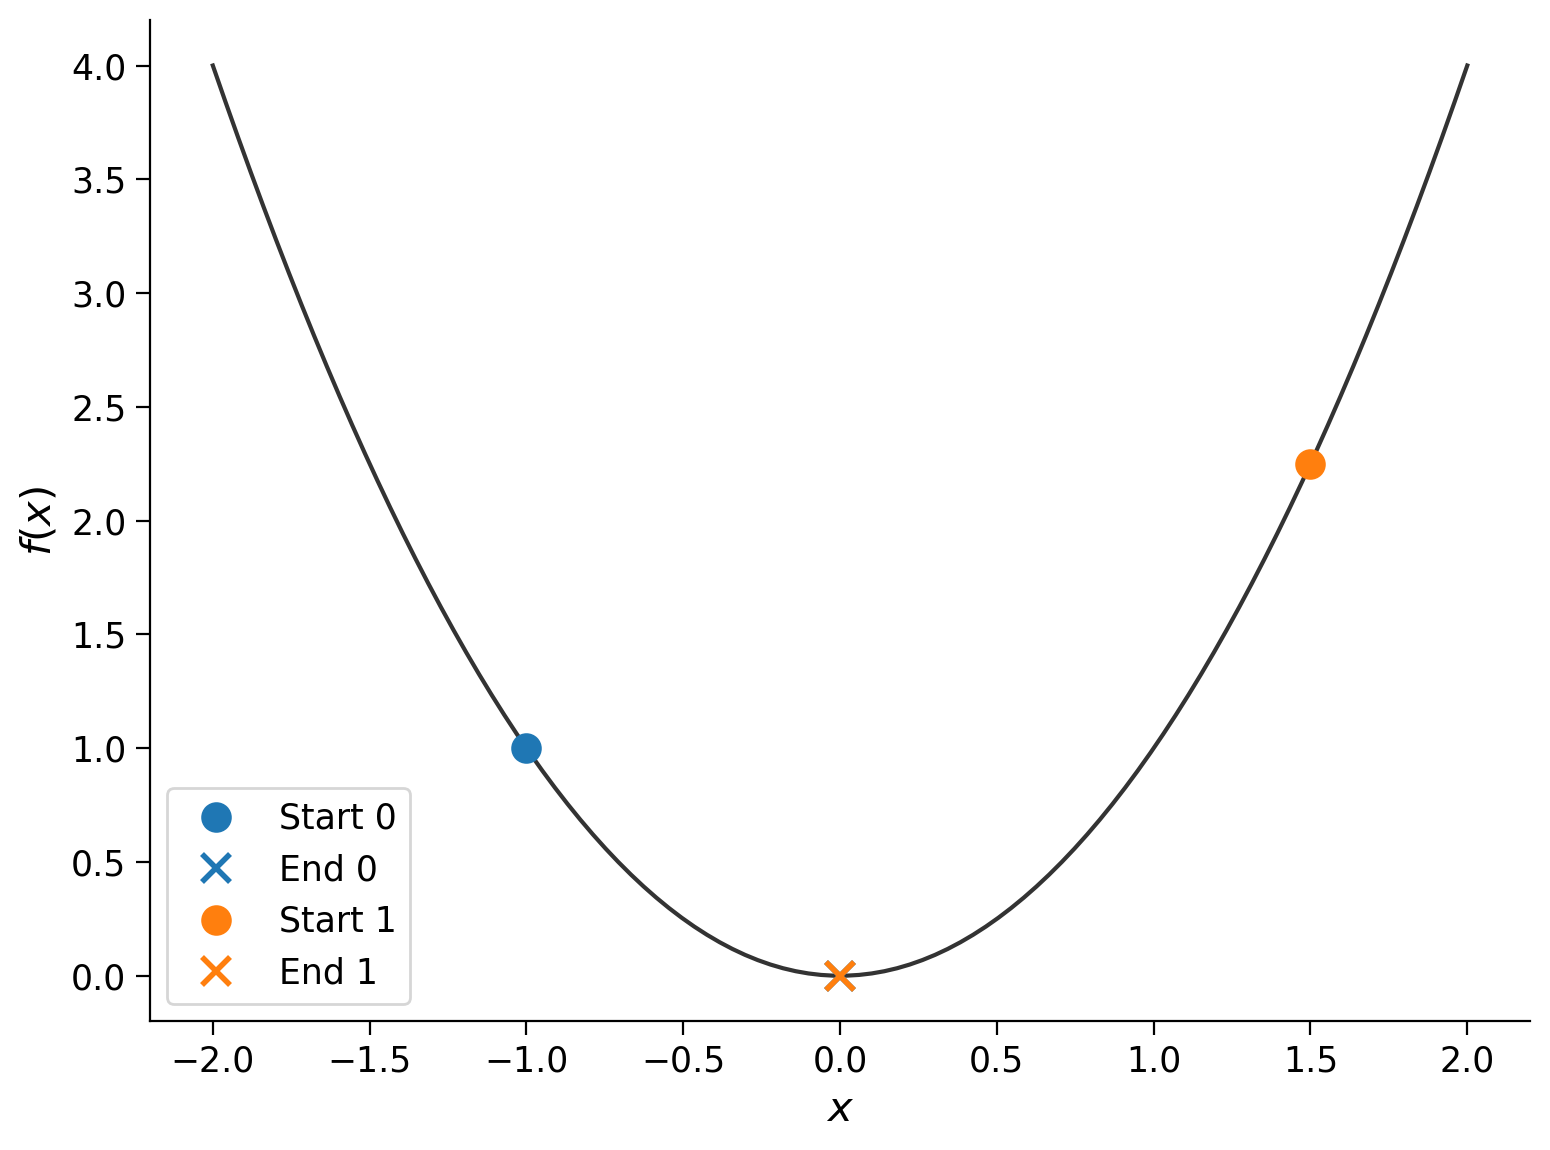

In [26]:
start_points = -1, 1.5

xx = np.linspace(-2, 2, 100)
plt.plot(xx, f(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(f, x0)
  plt.plot(x0, f(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", c=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

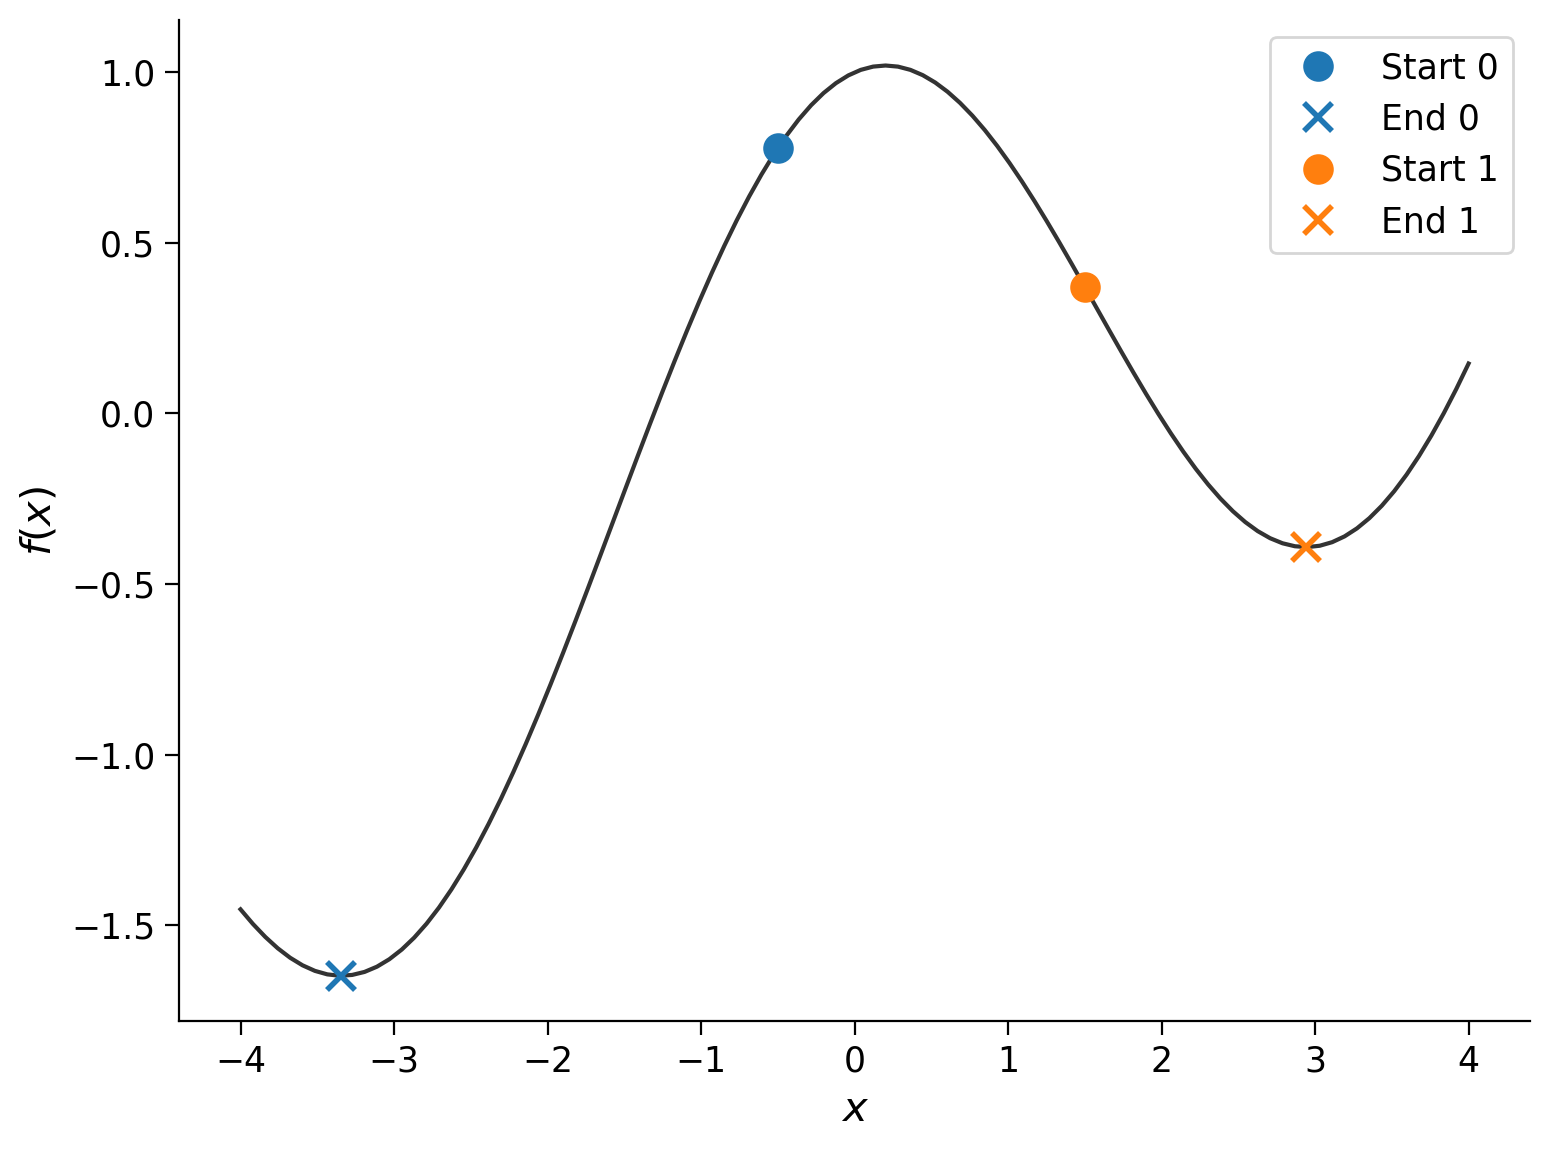

In [27]:
g = lambda x: x / 5 + np.cos(x)
start_points = -.5, 1.5

xx = np.linspace(-4, 4, 100)
plt.plot(xx, g(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(g, x0)
  plt.plot(x0, g(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", color=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 8616.14305177543
        x: [-2.005e+00 -2.009e-02 ...  3.532e-02 -2.036e-02]
      nit: 51
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 4.156e-04 -2.062e-05 ... -2.293e-05 -1.397e-05]
            [-2.062e-05  4.951e-04 ... -5.244e-05  3.387e-06]
            ...
            [-2.293e-05 -5.244e-05 ...  4.659e-04  2.699e-06]
            [-1.397e-05  3.387e-06 ...  2.699e-06  4.690e-04]]
     nfev: 2700
     njev: 100


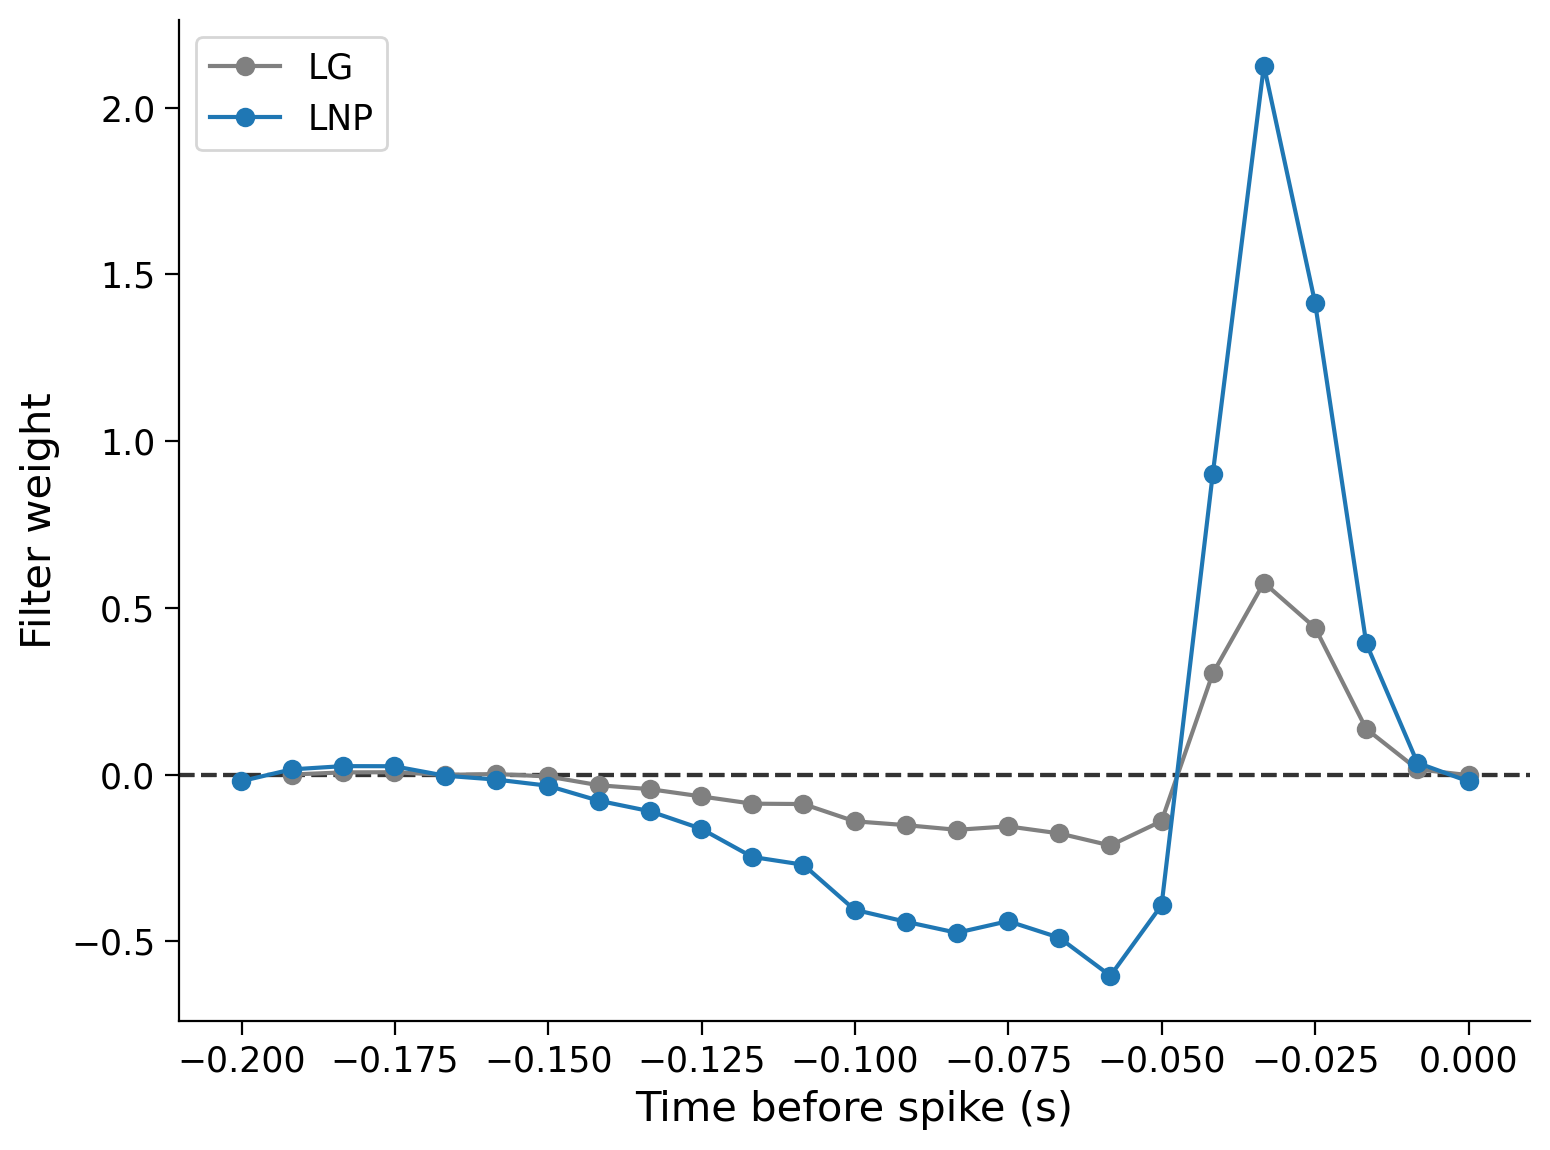

In [34]:
def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """

  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  # log_lik = y @ np.log(rate) - rate.sum()
  log_lik = y @ np.log(rate) - np.ones(len(rate))  @ rate

  return -log_lik


def fit_lnp(stim, spikes, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """
 
  # Build the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))
  print(res)

  return res["x"]


# Fit LNP model
theta_lnp = fit_lnp(stim, spikes)

# Visualize
plot_spike_filter(theta_lg[1:], dt_stim, show=False, color=".5", label="LG")
plot_spike_filter(theta_lnp[1:], dt_stim, show=False, label="LNP")
plt.legend(loc="upper left")
plt.show()

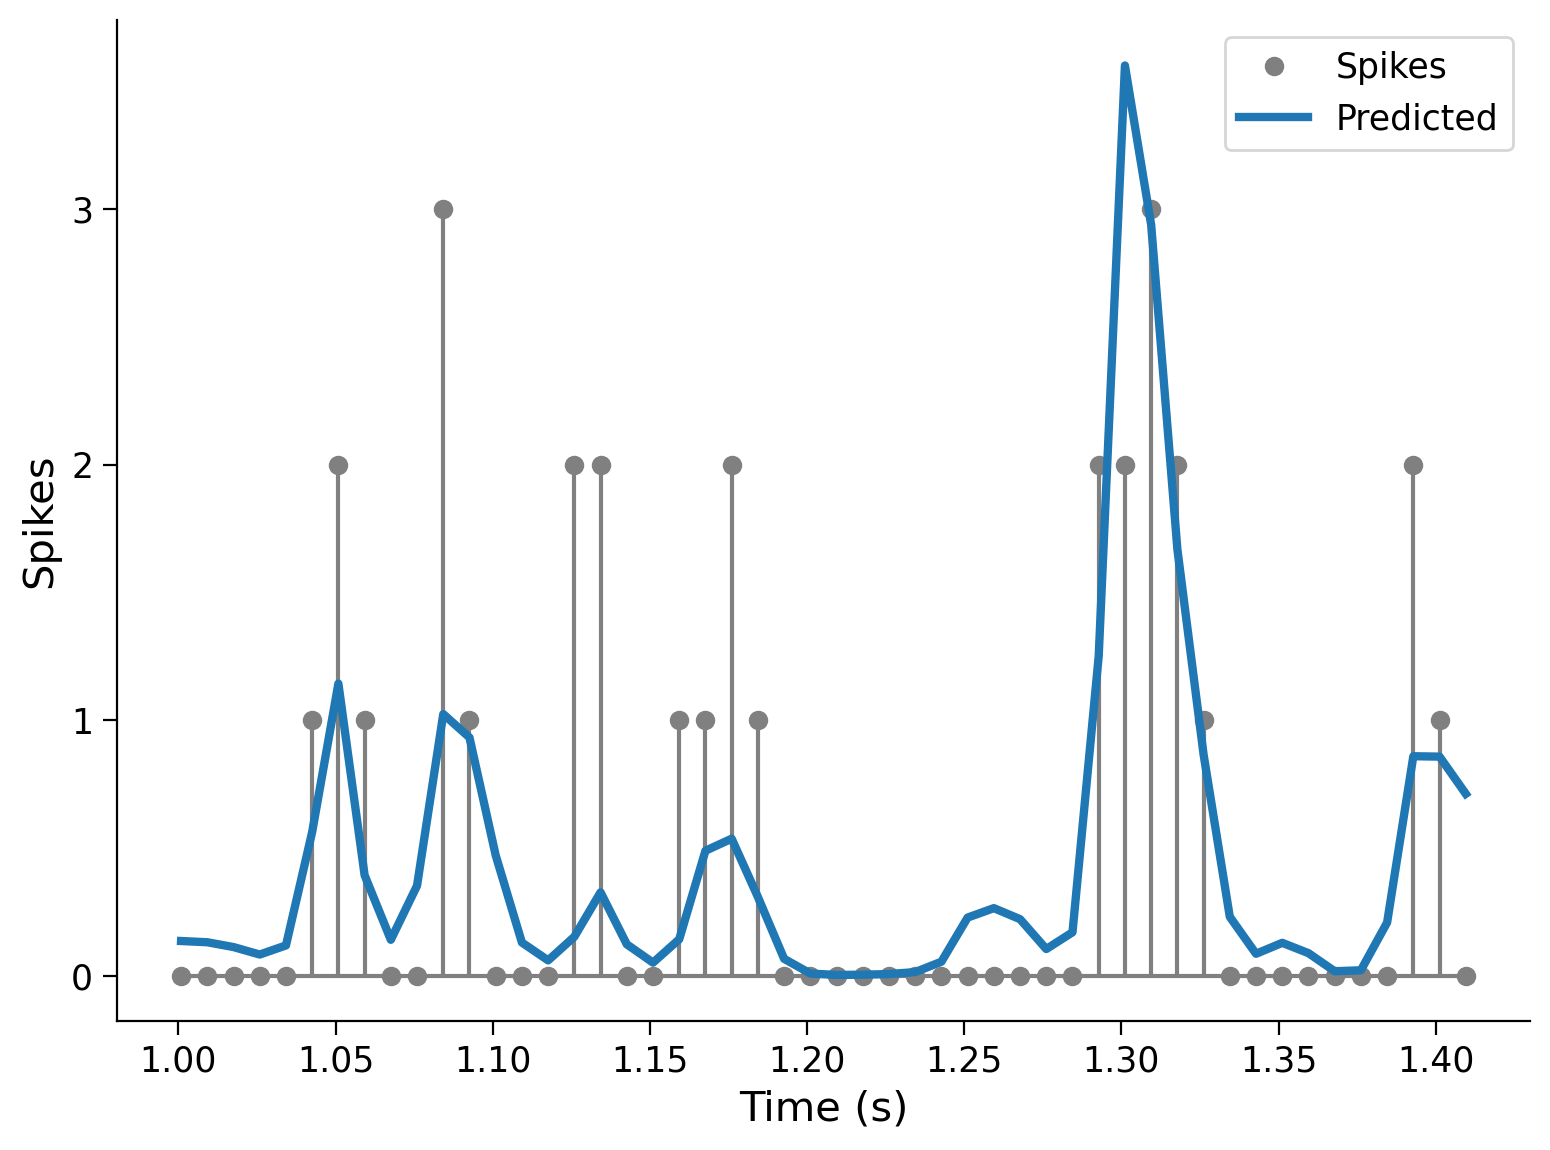

In [33]:
def predict_spike_counts_lnp(stim, spikes, theta=None, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    theta (1D array): Filter weights; estimated if not provided.
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """

  y = spikes
  constant = np.ones_like(spikes)
  X = np.column_stack([constant, make_design_matrix(stim)])
  if theta is None:  # Allow pre-cached weights, as fitting is slow
    theta = fit_lnp(X, y, d)

  yhat = np.exp(X @ theta)
  return yhat


# Predict spike counts
yhat = predict_spike_counts_lnp(stim, spikes, theta_lnp)

# Visualize
plot_spikes_with_prediction(spikes, yhat, dt_stim)

## Tutorial 2: Classifiers and Regularizers

In [36]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [37]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [38]:
# @title Plotting Functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze())
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()
  plt.show()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )
    plt.show()


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()


def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")
  plt.show()

In [39]:
#@title Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

#### Section 1.1: The logistic regression model

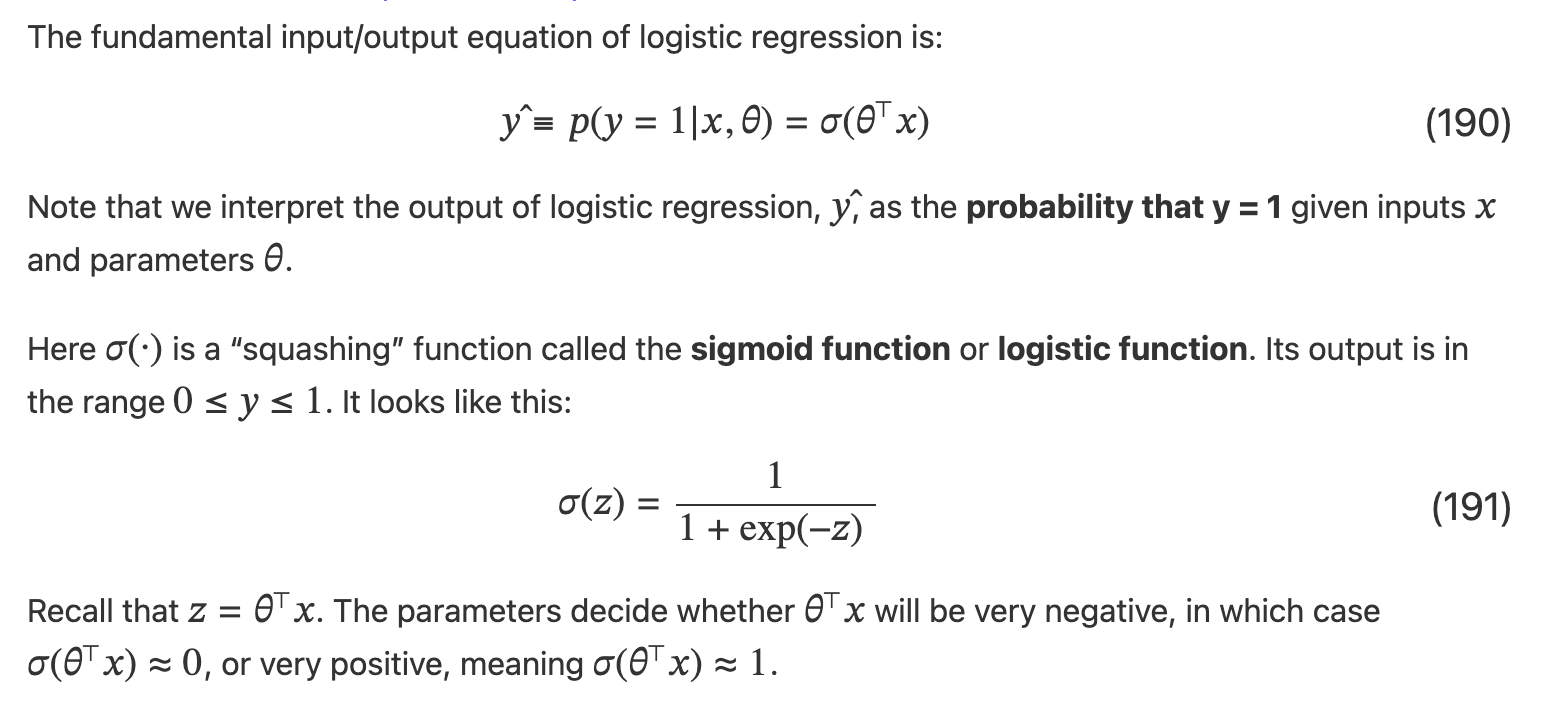

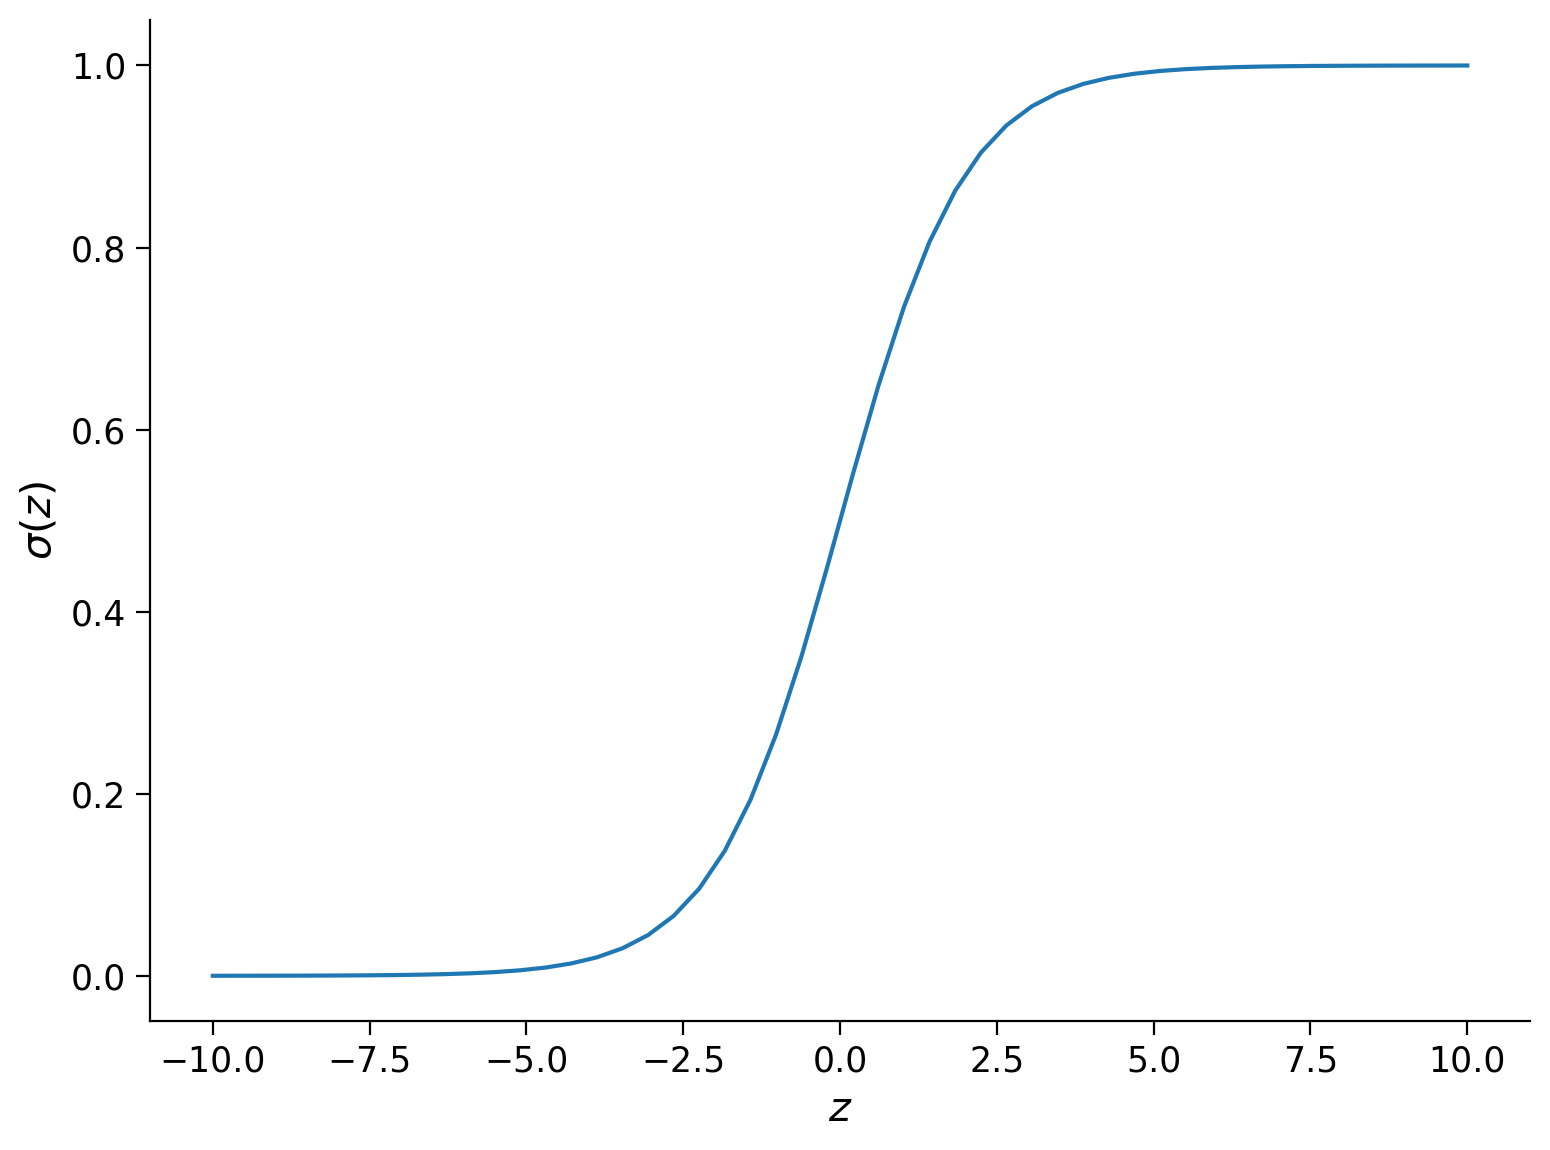

In [41]:
def sigmoid(z):
  """Return the logistic transform of z."""

  sigmoid = 1 / (1 + np.exp(-z))

  return sigmoid


# Visualize
plot_function(sigmoid, "\sigma", "z", (-10, 10))

#### Section 1.2: Using scikit-learn

### Section 2: Decoding neural data with logistic regression

#### Section 2.1: Setting up the data


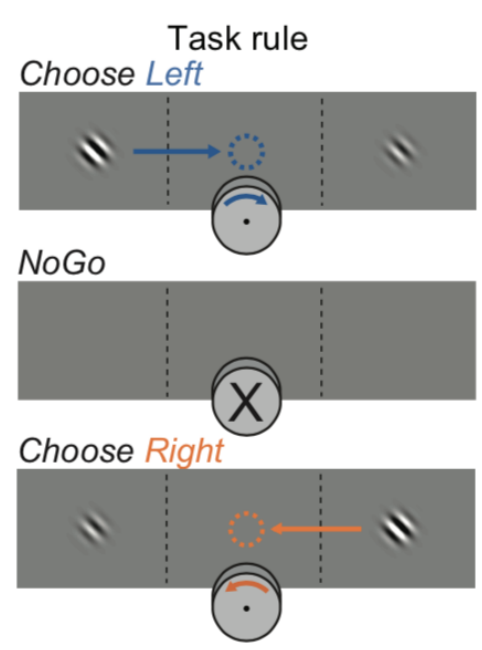

In [42]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/steinmetz-task.png")

In [43]:
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

spikes (276, 691)
choices (276,)


In the previous notebook, y corresponded to the neural data, and X corresponded to something about the experiment. Here, we are going to invert those relationships. That’s what makes this a decoding model: we are going to predict behaviour (y) from the neural responses (X):

In [52]:
y = data["choices"]
X = data["spikes"] # one column per neuron - features are averaged firing rate across trial

In [45]:
# Define the model
log_reg = LogisticRegression(penalty=None)

# Fit it to data
log_reg.fit(X, y)

LogisticRegression(penalty=None)

In [46]:
y_pred = log_reg.predict(X)

### Section 2.4: Evaluating the model

In [48]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(X)

  accuracy = np.mean(y == y_pred)

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


In [49]:
accuracies = cross_val_score(LogisticRegression(penalty=None), X, y, cv=8)  # k=8 cross validation

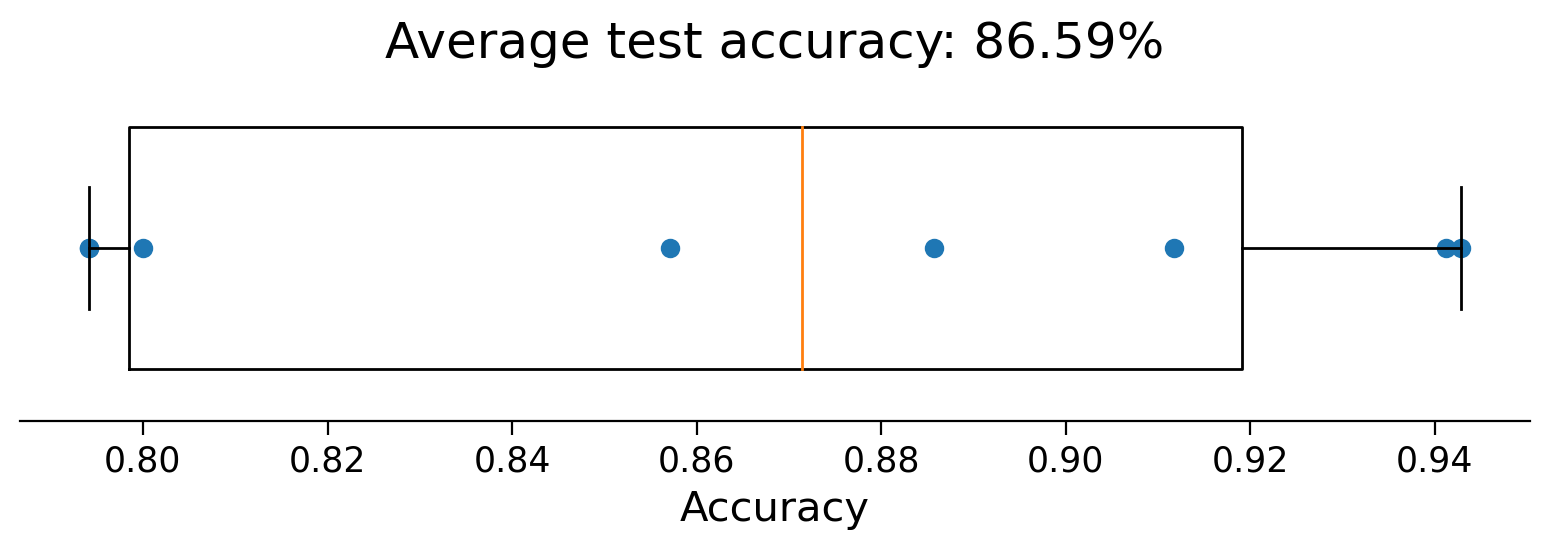

In [50]:
# @markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

The model has almost three times as many features as samples. This is a situation where overfitting is very likely (almost guaranteed).

**Why more features than samples leads to overfitting**

In brief, the variance of model estimation increases when there are more features than samples. That is, you would get a very different model every time you get new data and run .fit(). This is very related to the bias/variance tradeoff you learned about on day 1.

Why does this happen? Here’s a tiny example to get your intuition going. Imagine trying to find a best-fit line in 2D when you only have 1 datapoint. There are simply an infinite number of lines that pass through that point. This is the situation we find ourselves in with more features than samples.

**What we can do about it**

As you learned on day 1, you can decrease model variance if you don’t mind increasing its bias. Here, we will increase bias by assuming that the correct parameters are all small. In our 2D example, this is like preferring the horizontal line to all others. This is one example of regularization.

### Section 3: Regularization

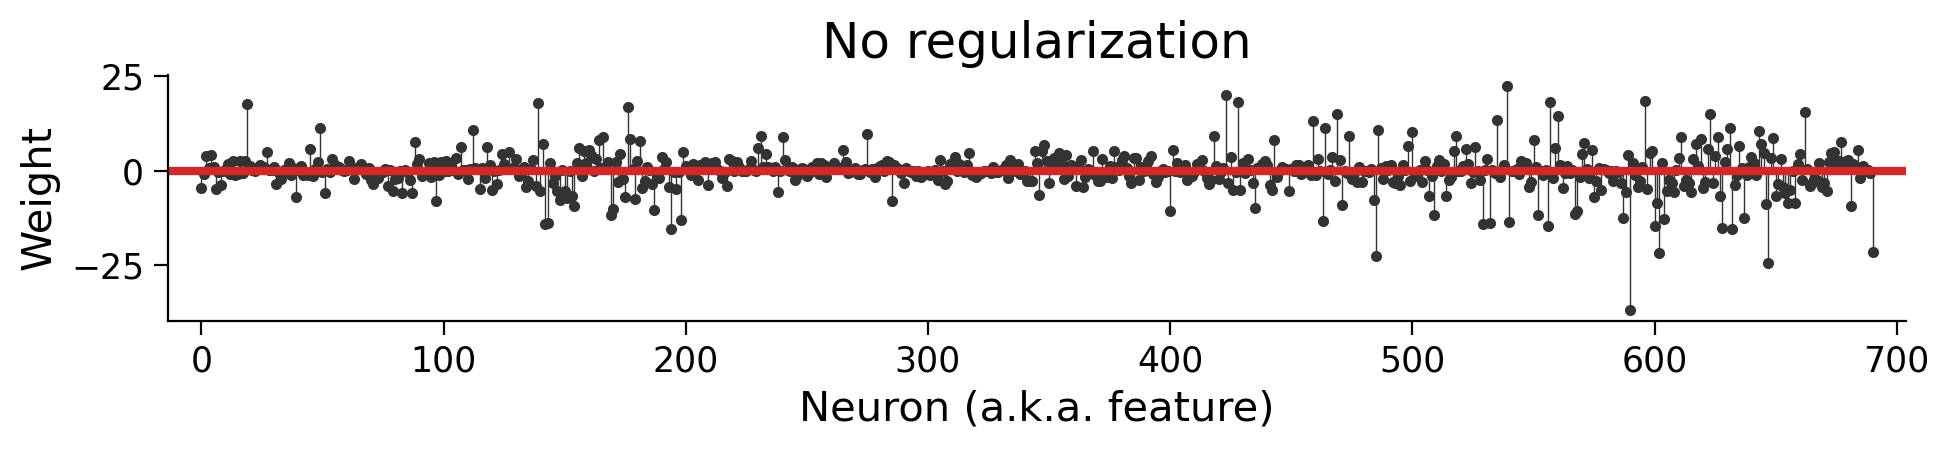

In [51]:
log_reg = LogisticRegression(penalty=None).fit(X, y)
plot_weights({"No regularization": log_reg})

It’s important to understand this plot. Each dot visualizes a value in our parameter vector 𝜃
. (It’s the same style of plot as the one showing 𝜃
 in the video). Since each feature is the time-averaged response of a neuron, each dot shows how the model uses each neuron to estimate a decision.

#### Section 3.1: L2 (Ridge) regularization

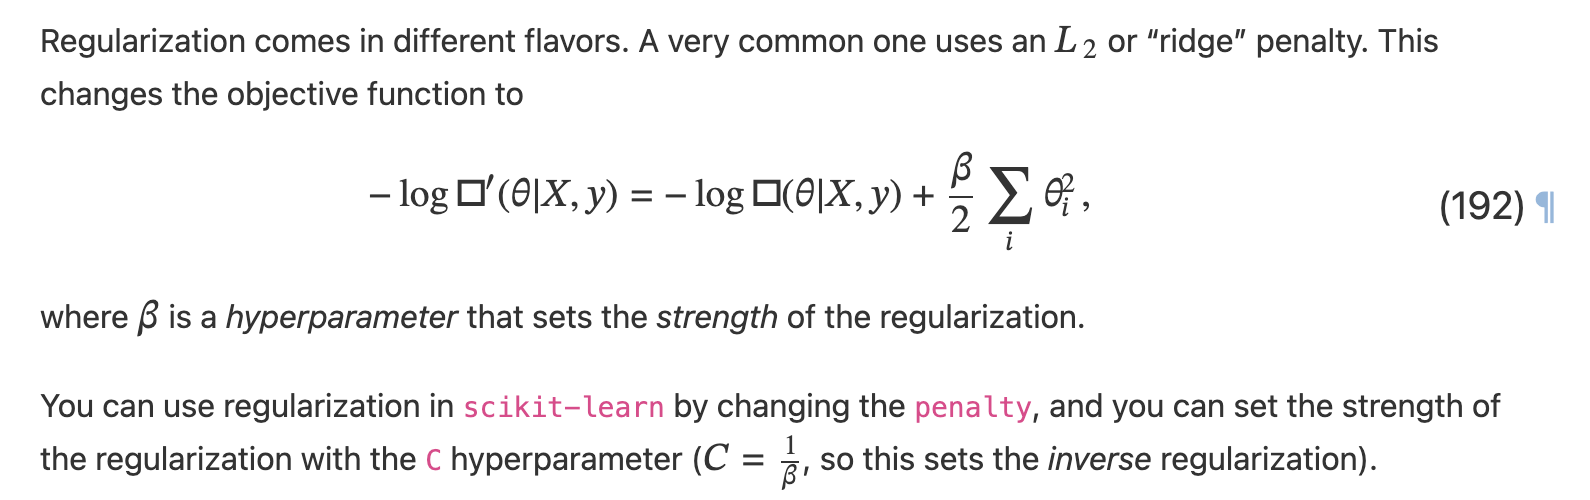

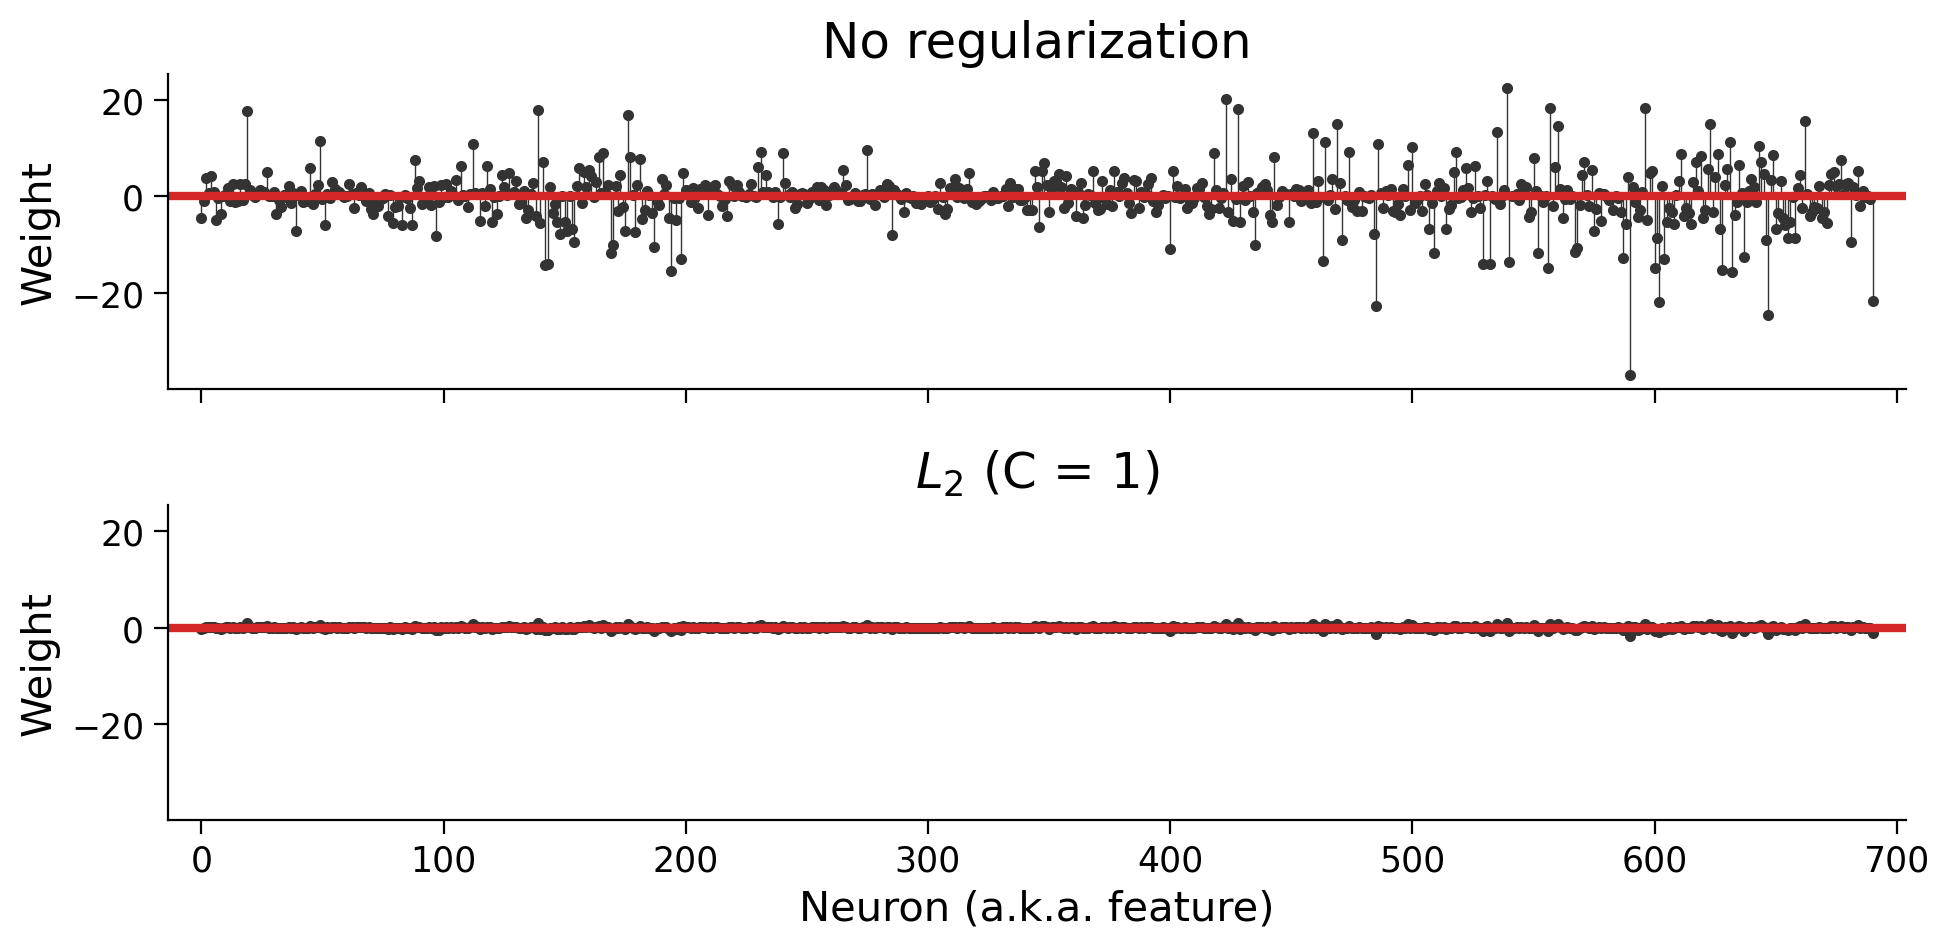

In [53]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
}
plot_weights(models)

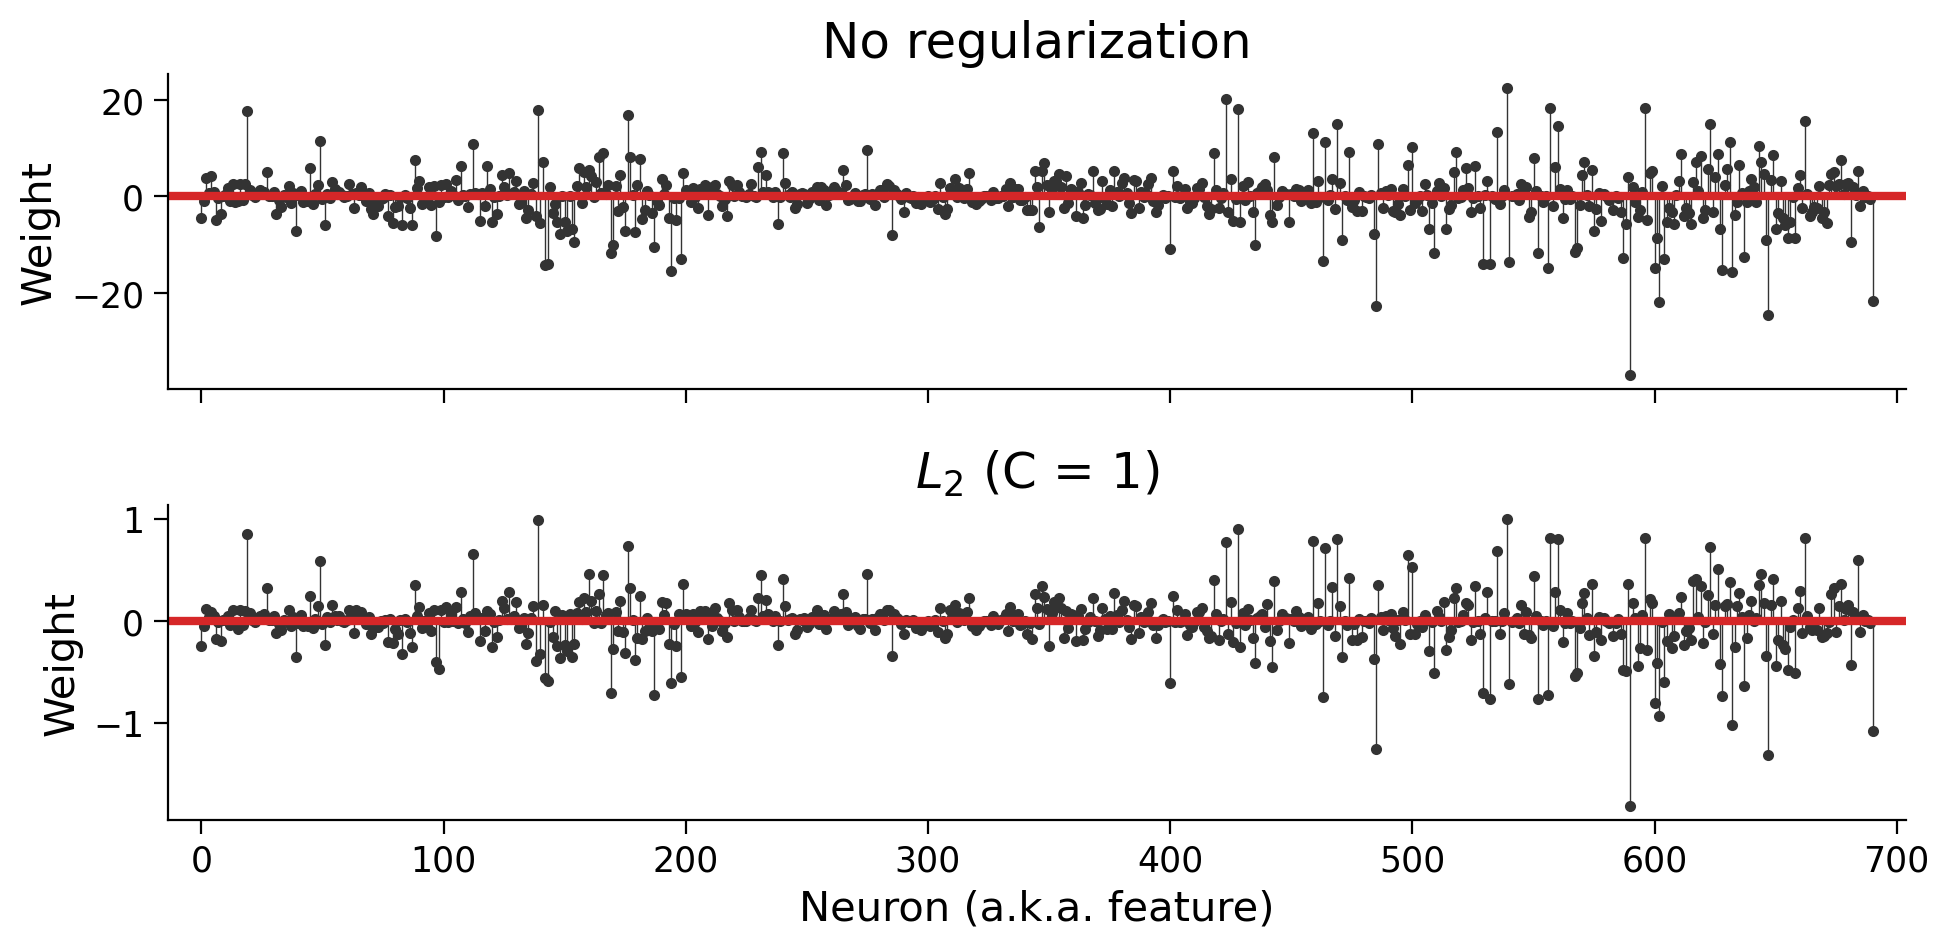

In [54]:
plot_weights(models, sharey=False)

Now you can see that the weights have the same basic pattern, but the regularized weights are an order-of-magnitude smaller.



In [55]:
# @markdown Execute this cell to enable the widget!

# Precompute the models so the widget is responsive
log_C_steps = 1, 11, 1
penalized_models = {}
for log_C in np.arange(*log_C_steps, dtype=int):
  m = LogisticRegression("l2", C=10 ** log_C, max_iter=5000)
  penalized_models[log_C] = m.fit(X, y)

@widgets.interact
def plot_observed(log_C = widgets.FloatSlider(value=1, min=1, max=10, step=1)):
  models = {
    "No regularization": log_reg,
    f"$L_2$ (C = $10^{log_C}$)": penalized_models[log_C]
  }
  plot_weights(models)

interactive(children=(FloatSlider(value=1.0, description='log_C', max=10.0, min=1.0, step=1.0), Output()), _do…

### Section 3.2: L1 (Lasso) regularization

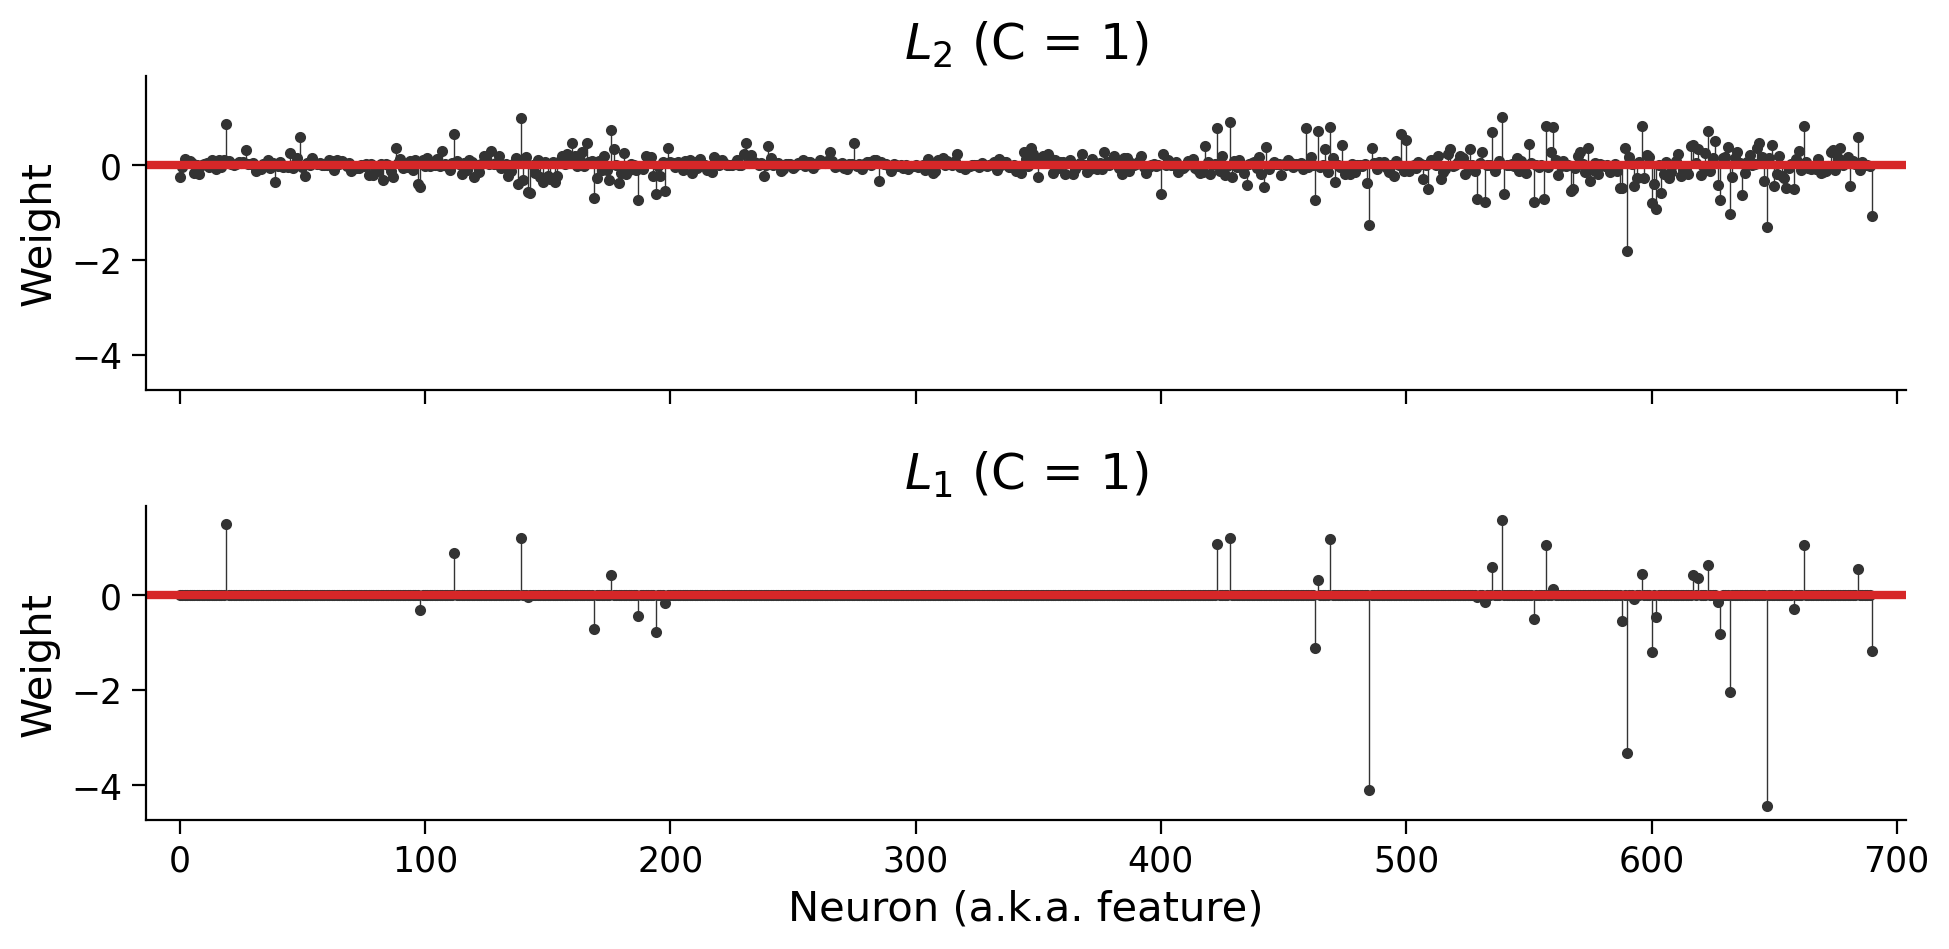

In [56]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

### Section 3.3: The key difference between L1 and L2 regularization: sparsity


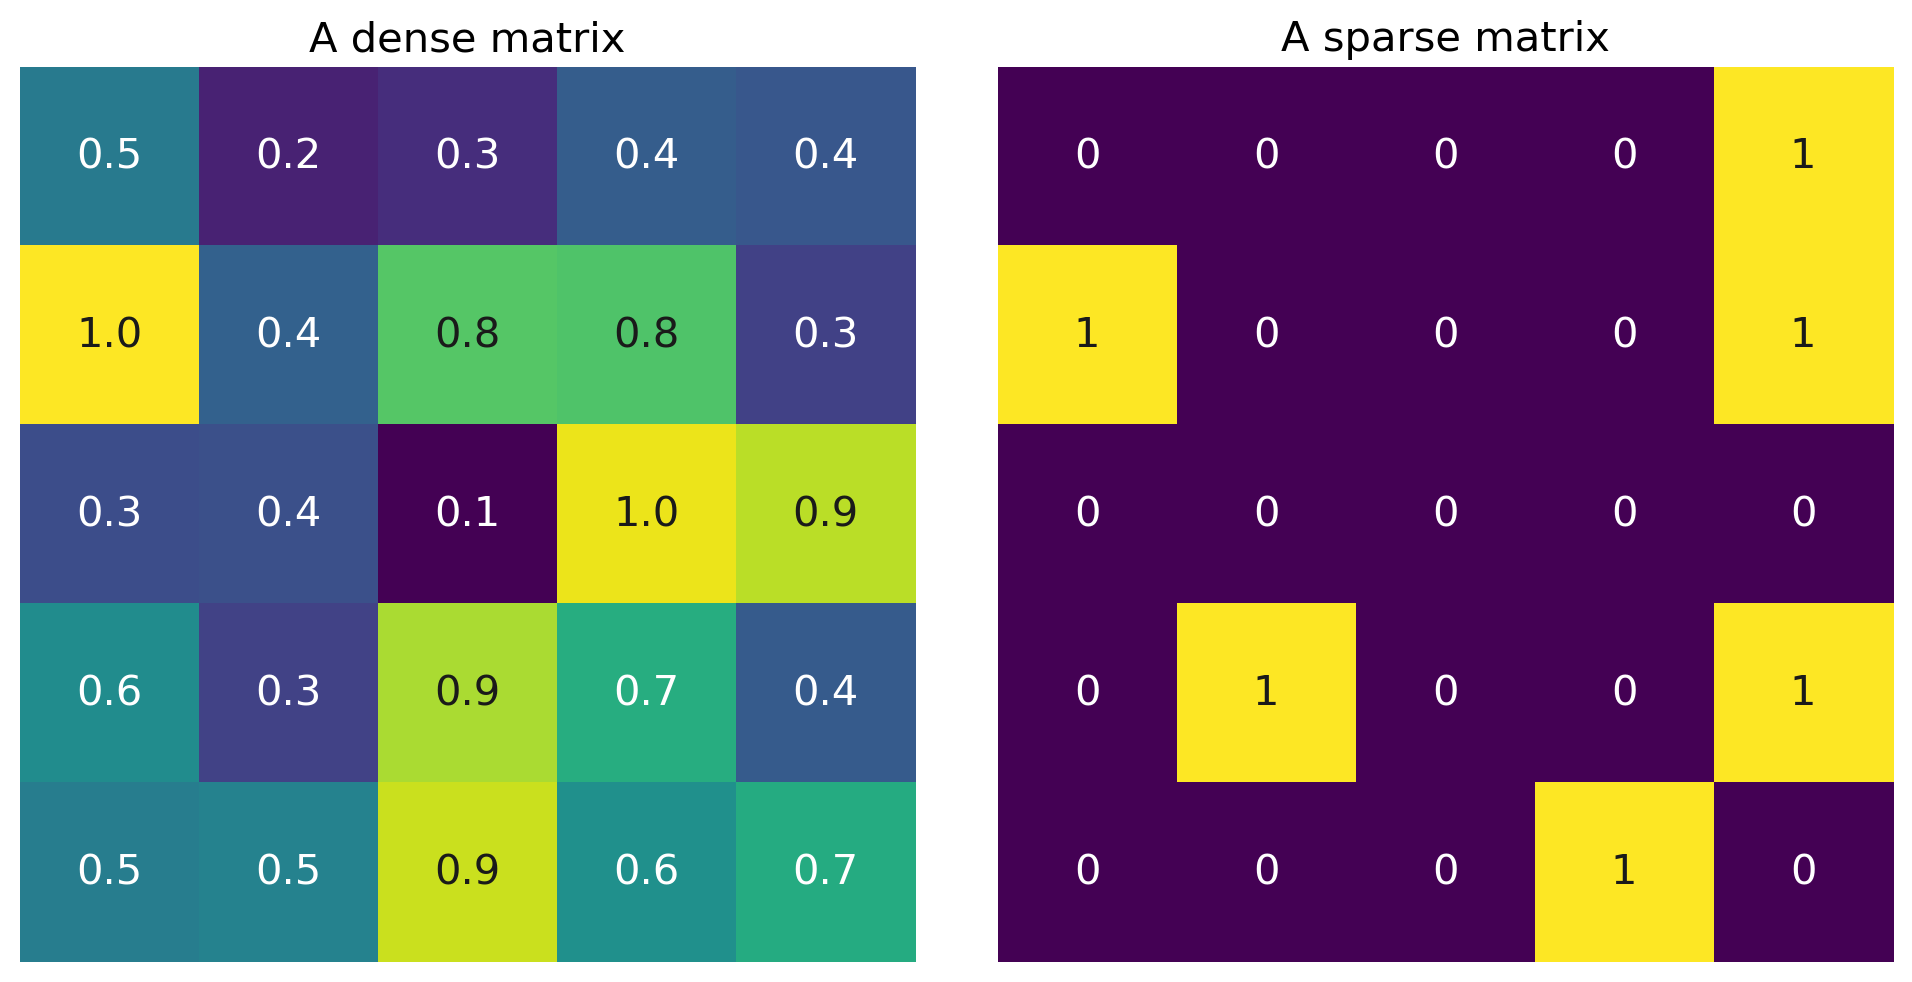

In [57]:
# @markdown Execute to plot a dense and a sparse matrix
np.random.seed(50)
n = 5
M = np.random.random((n, n))
M_sparse = np.random.choice([0, 1], size=(n, n), p=[0.8, 0.2])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

axs[0].imshow(M)
axs[1].imshow(M_sparse)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title("A dense matrix", fontsize=15)
axs[1].set_title("A sparse matrix", fontsize=15)
text_kws = dict(ha="center", va="center")
for i in range(n):
  for j in range(n):
    iter_parts = axs, [M, M_sparse], ["{:.1f}", "{:d}"]
    for ax, mat, fmt in zip(*iter_parts):
      val = mat[i, j]
      color = ".1" if val > .7 else "w"
      ax.text(j, i, fmt.format(val), c=color, **text_kws)
plt.show()

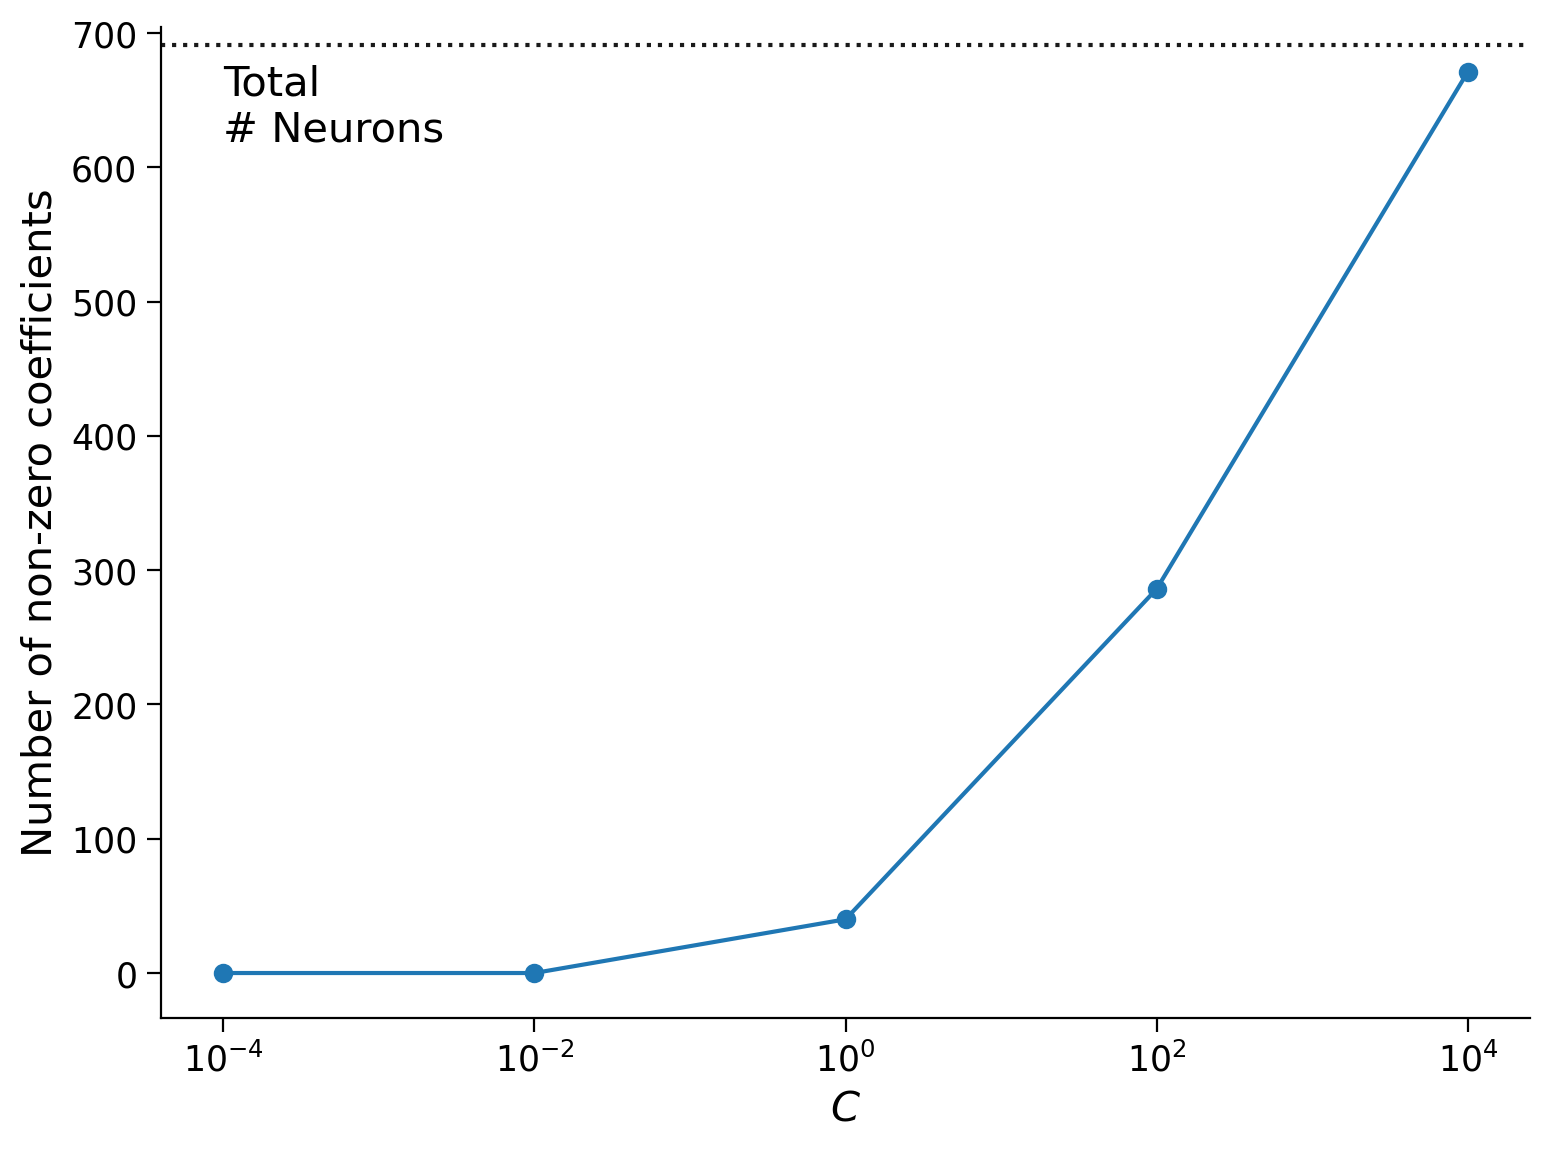

In [62]:
def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values

  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero

  """

  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X, y)

    # Get the coefs of the fit model (in sklearn, we can do this using model.coef_)
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.sum(coefs != 0)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

# Count non zero coefficients
non_zero_l1 = count_non_zero_coefs(X, y, C_values)

# Visualize
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X.shape[1])

Link to neuroscience: When is it OK to assume that the parameter vector is sparse? Whenever it is true that most features don’t affect the outcome. One use-case might be decoding low-level visual features from whole-brain fMRI: we may expect only voxels in V1 and thalamus should be used in the prediction.

### Section 3.4: Choosing the regularization penalty

/Users/sepideh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sepideh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

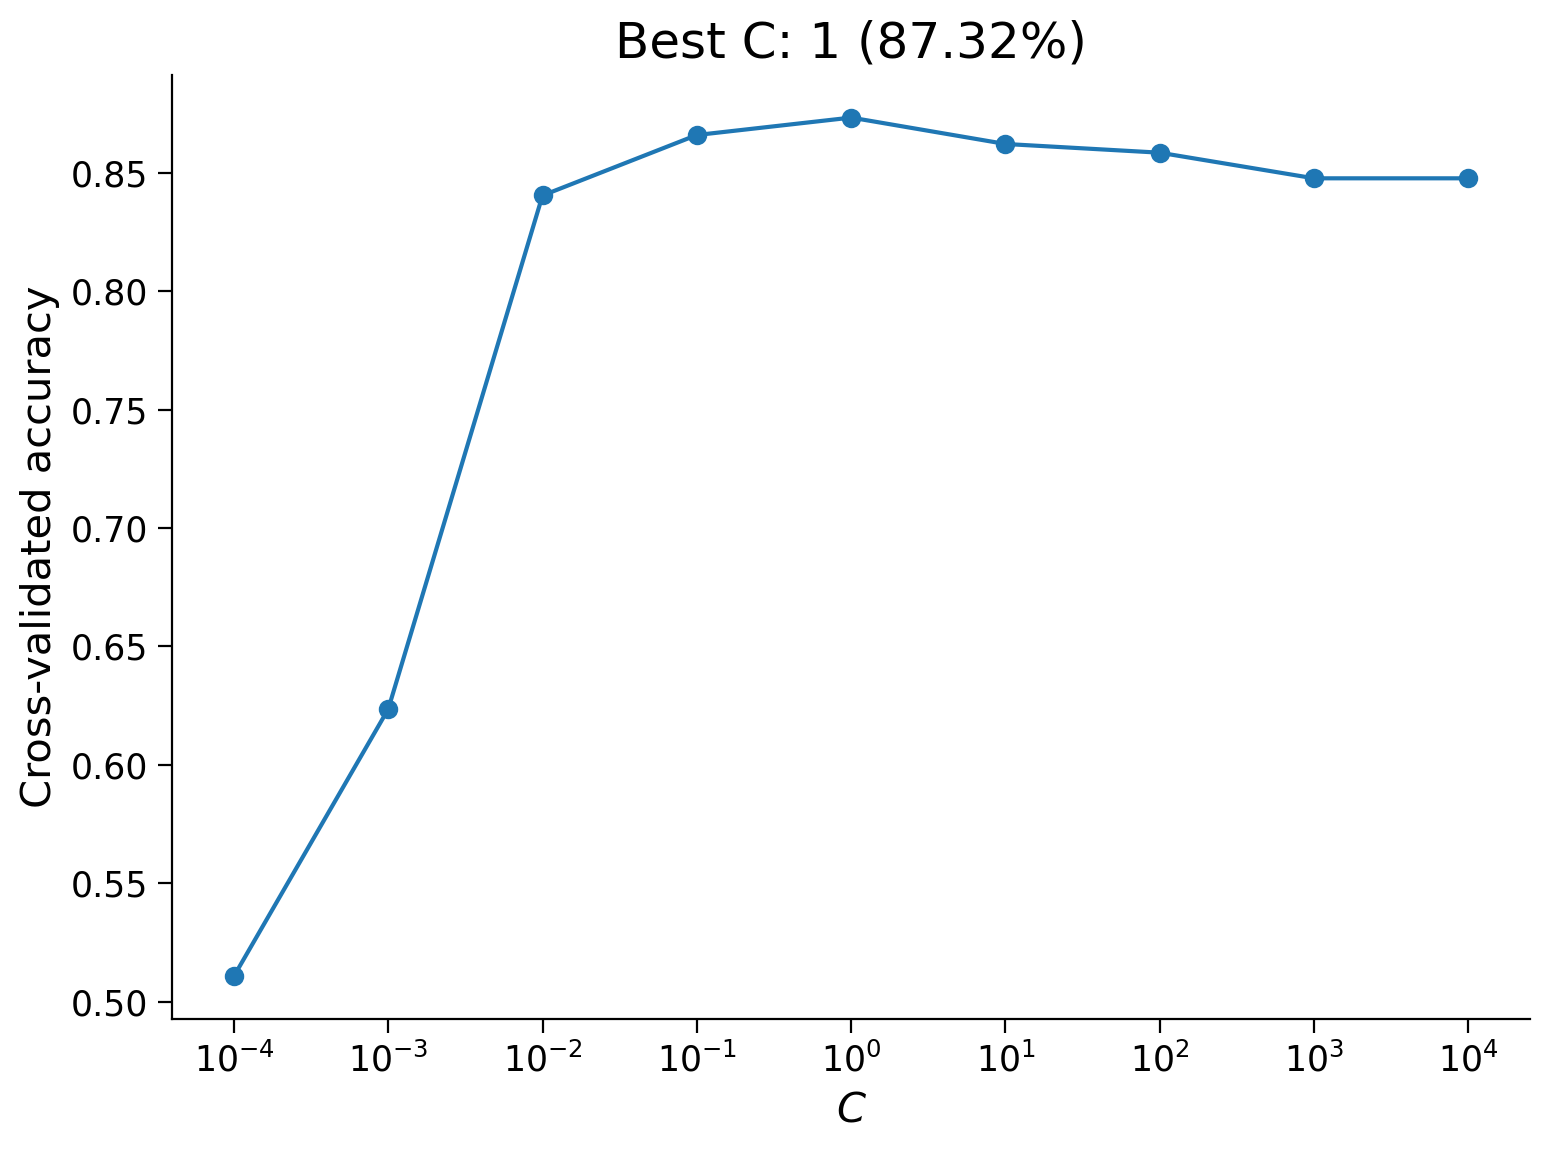

In [65]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

  Returns:
    accuracies (1D array): CV accuracy with each value of C

  """

  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C).fit(X, y)
    model.fit(X, y)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies)

### Bonus Section 1: The Logistic regression model in full

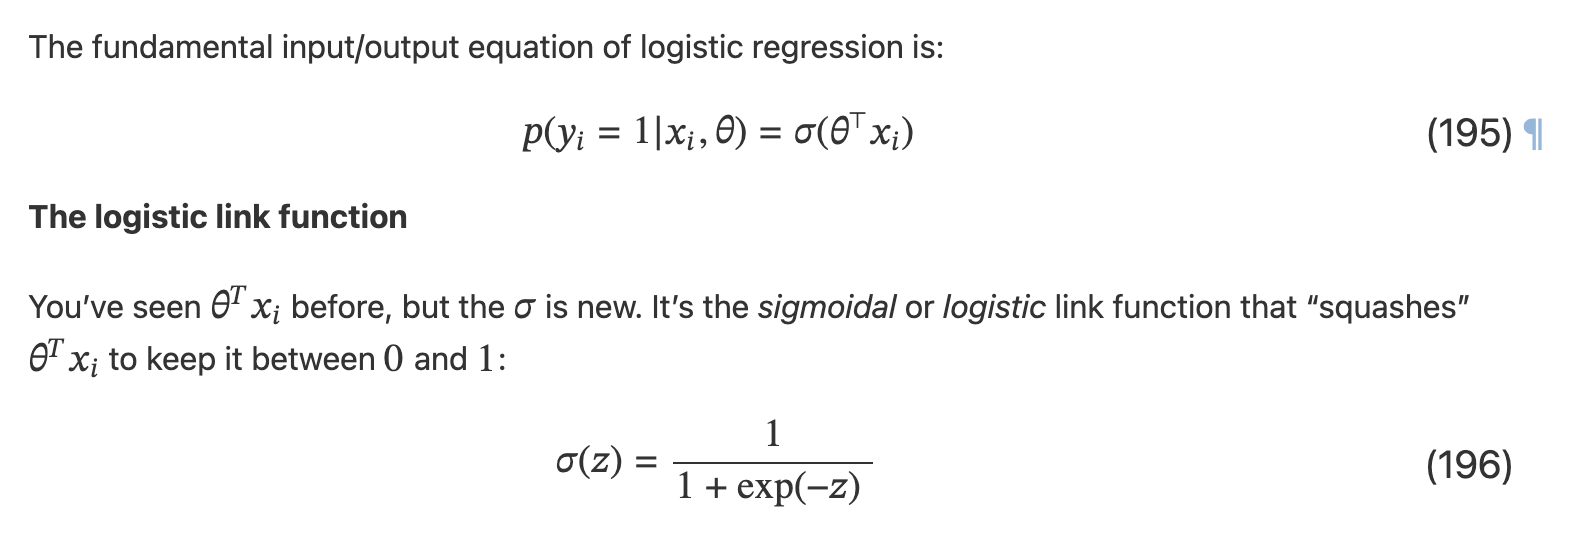

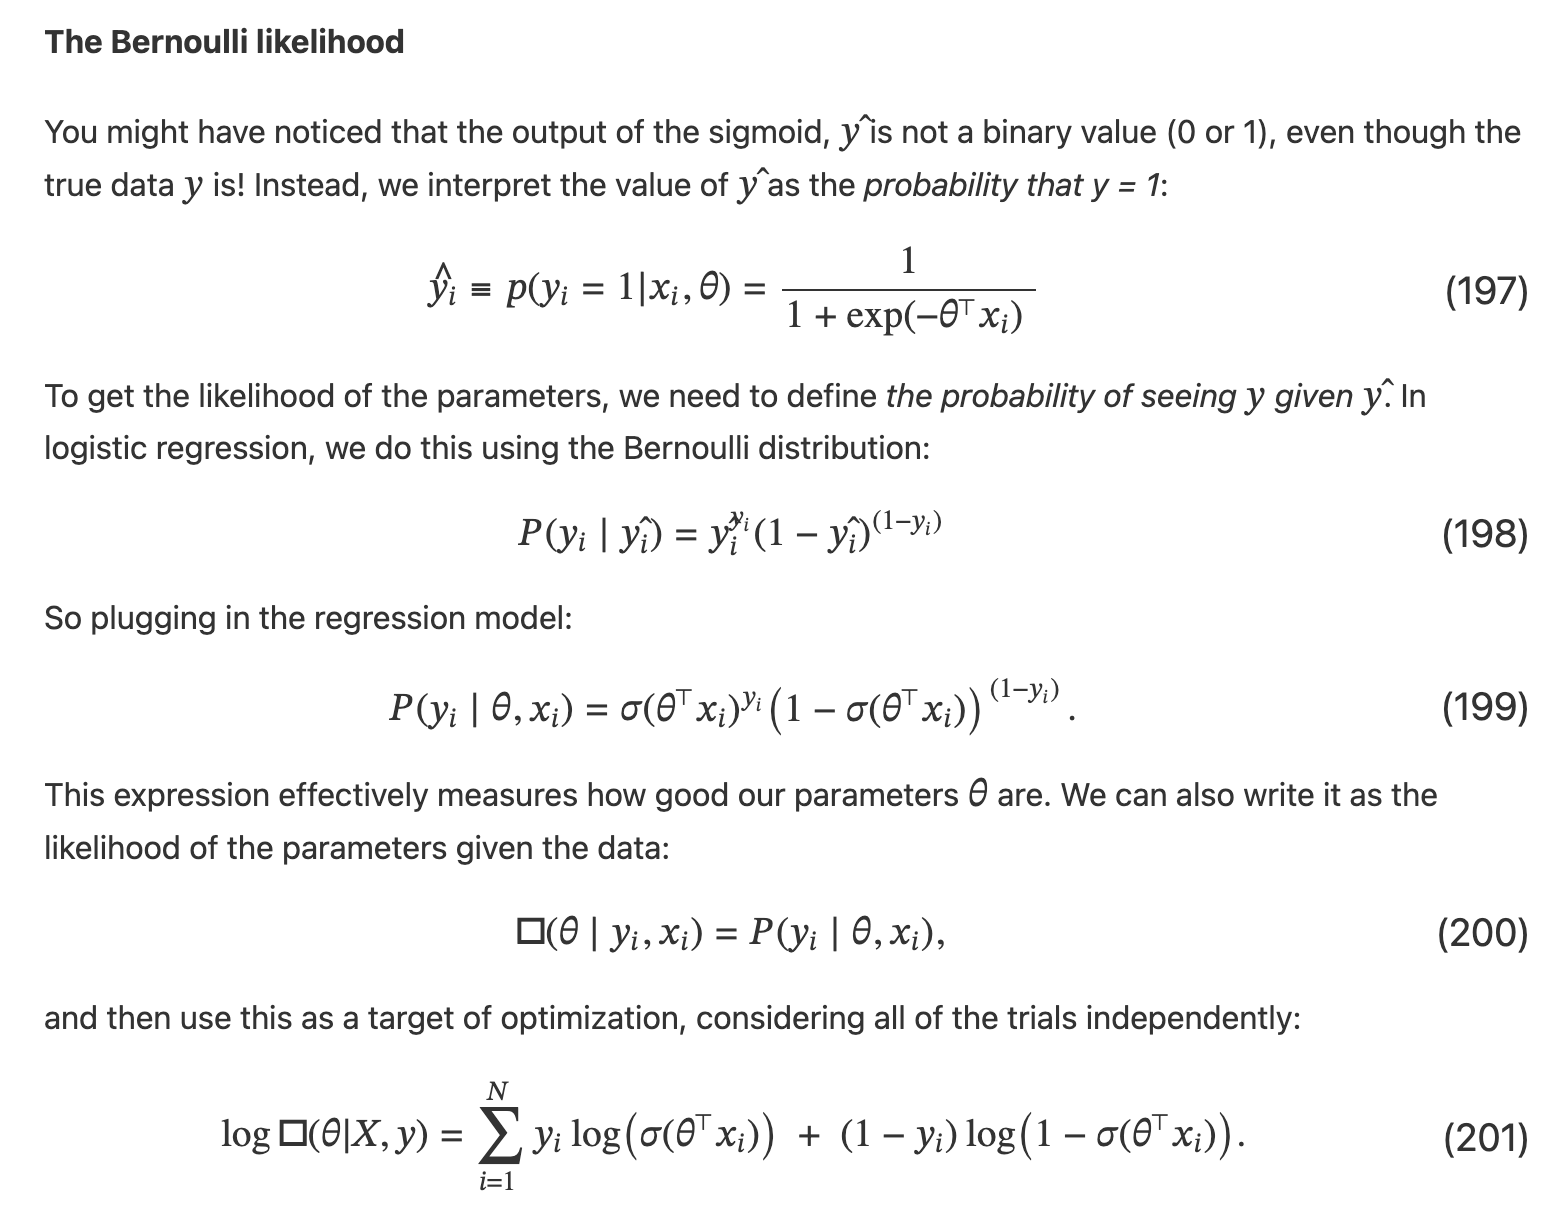